# TODO

- [ ] Plug inflation in housing stock
- [ ] Add other autonomous expenditure

In [1]:
#!pip install pysolve3

Time checking:

In [2]:
from datetime import datetime
t1 = datetime.now()

# Introduction

Jupyter notebook for the simplest model scratch. By convention, all exogenous variables are presented with a overline line (*e.g.* $\overline a$) and the parameters are represented by greek letters (*e.g.* $\alpha$). The code in this document is executable and is strongly recommend to do the follow to ensure that the output is corrected and updated:

Run time > Restart and run all...

# Changes

In this version, the households are splitted in workers and capitalists where workers spend all their income white capitalists spend a share o distributed profits.

# Equations

## General Equations

$$
Y = C + I
$$

$$
C = C_w + C_k
$$

$$
I = I_f + I_h
$$

$$
\omega = \overline \omega
$$

$$
W = \omega \cdot  Y
$$

$$
Y_K = \frac{K_f}{\overline v}
$$

$$
u = \frac{Y}{Y_K}
$$

$$
g_k = \frac{h\cdot u}{v}
$$

$$
Z = I_h
$$

$$
K = K_f + K_{HD}
$$

## Households

$$
C_w = \alpha\cdot W
$$

$$
C_k = \alpha_2\cdot FD
$$

$$
YD_w = W
$$

$$
YD_k = FD + \overline r_{m-1}\cdot M_{-1} - \overline r_{mo-1}\cdot MO
$$


$$
Sh_w = YD_w - C_w = 0
$$


$$
Sh_k = YD_k - C_k = \Delta M
$$


$$
\Delta MO = I_h
$$

$$
V_h = M + K_H - MO
$$

$$
NFW_h = S_h - I_h
$$

$$
\text{Residual} = \Delta M - \Delta L_f 
$$

## Firms

$$
\Delta L_f = I_f - FU
$$

$$
FT = Y - W = FU+ FD
$$

$$
FU = \gamma_F\cdot (FT - r_{L_{-1}}\cdot L_{f_{-1}})
$$


$$
FD = (1 - \gamma_F)\cdot (FT - r_{L_{-1}}\cdot L_{f_{-1}})
$$

$$
I_f = h\cdot Y
$$

$$
\Delta K_f = I_f
$$

$$
\Delta h = 
h_{-1}\cdot \gamma_u\cdot (u - \overline u_n)
$$

$$
V_f = K_f  - L_f
$$

$$
NFW_f = FU - I_f
$$

## Banks

$$
L = L_f
$$

$$
\Delta M = \Delta L + \Delta MO
$$

$$
NFW_b = rl_{-1}\cdot L_{-1} + rmo_{-1}\cdot MO_{-1} - rm_{-1}\cdot M_{-1}
$$

$$
r_l = r_m + spread_l (=0)
$$

$$
r_{mo} = r_m + spread_{mo} (=0)
$$

$$
V_b = L + MO - M
$$

## Residential Investment


$$
K_{HS} = K_{HD}
$$

$$
I_h^S = I_h
$$

$$
\Delta K_{HD} = I_h
$$

$$
I_h = (1+g_Z)\cdot I_{h_{-1}}
$$


$$
k = \frac{K_h\cdot p_h}{K}
$$

$$
g_Z = \phi_0 - \phi_1\cdot own
$$

$$
own = \left(\frac{1+r_{mo}}{1+\dot p}\right) -1
$$

# Simulation setup

## Loading libraries

In [3]:
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sns
import networkx as nx
import sympy as sp
from sympy import pprint, cse

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual


plt.style.use('seaborn-white')

from pysolve3.model import Model
from pysolve3.utils import SolveSFC, ShockModel, SummaryShock, SFCTable

/home/gpetrini/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/__init__.py:62: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


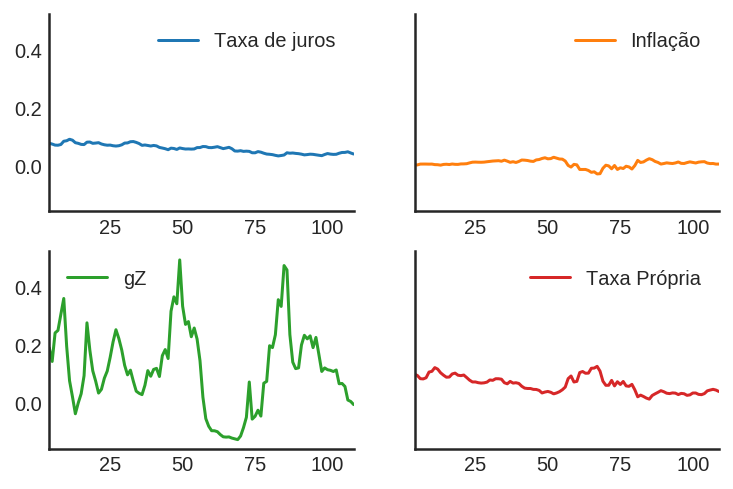

In [4]:
data = pd.read_csv('../SeriesTemporais/Dados_yeojohnson.csv')

data = data[[
    "Taxa de juros", 
    "Inflação", 
    "gZ", 
    "Crise", 
    "Taxa Própria",
]]
        
data = data.dropna()

fig, ax = plt.subplots()

data.drop('Crise', axis='columns').plot(ax=ax, subplots=True, layout=(2,2), sharex=False, sharey=True)
ax.axhline(y=0, ls='--', color='black')
sns.despine()
plt.show()
fig.savefig('YeoJohnson.png', dpi=300, bbox_inches = 'tight',)

# Creating model function

In [5]:
def model(
    alpha = 1,
    alpha_2 = .3,
    gamma_F = 0.95,
    gamma_u = 0.01,
    g_Z = 0.05,
    omega = 0.3,
    rm = 0.02,
    spread_l = 0,
    spread_mo = 0,
    un = 0.8,
    v = 2.5,
    phi_0 = 0.04,
    phi_1 = 0.02,
    infla = 0.0,
    phparam=1.0
):
  """
  phparam: 1.0 means no inflation
  """
  model = Model()
  model.set_var_default(0) 
  model.var('C', desc='Total Consumption')
  model.var('C_w', desc='Workers Consumption')
  model.var('C_k', desc='Capitalists Consumption')
  model.var('FD', desc='Distributed profits')
  model.var('Fn', desc='Net profits')
  model.var('FT', desc='Total Profits')
  model.var('FU', desc='Retained profits')
  model.var('gk', desc='Capital growth rate', default=0.01)
  model.var('g_Z', desc='Autonomous grouth rate', default=g_Z)
  model.var('h', desc='Marginal propensity to invest (non-residential)', default=0.30)
  model.var('I_t', desc='Investment', default = 100) # 200
  model.var('I_f', desc='Non-residential investment') # 100
  model.var('I_h', desc='Residential investment', default = 100) # 100
  model.var('Is', desc='Residential investment (Supply)', default = 100) # 100
  model.var('K_HS', desc='Houses supply', default=500) # 500
  model.var('K_HD', desc='Houses demand', default=500) # 500
  model.var('K_f', desc='Non-residential capital', default = 1000) # 10000
  model.var('Knom', desc='Nominal Capital', default=1500)
  model.var('K', desc='Real Capital', default=1500)
  model.var('K_k', desc="% of Kf in total")
  model.var('L', desc='Total Loans') # 100
  model.var('Lf', desc='Firms Loans') # 100
  model.var('M', desc='Money deposits', default = 310) # 300
  model.var('MO', desc='Mortgages', default = 300) # 200
  model.var('NFW_h', desc='Households Net Financial Wealth')
  model.var('NFW_f', desc='Firms Net Financial Wealth')
  model.var('NFW_b', desc='Banks Net Financial Wealth')
  model.var('own', desc='Own interest rate', default = 0.02)
  model.var('ph', desc='House price', default = 1)
  model.var('rl', desc='Interests rates on loans')
  model.var('rmo', desc='Interests rates on mortgages')
  model.var('Sh_w', desc='Workers savings', default = 0)
  model.var('Sh_k', desc='Capitalist savings', default = 100)
  model.var('u', desc='Capacity utilization ratio', default=0.7)
  model.var('V_h', desc='Household net financial wealth', default = 500)
  model.var('V_f', desc='Firms net financial wealth', default = 1000)
  model.var('V_b', desc='Banks net financial wealth')
  model.var('W', desc='Wages')
  model.var('Y', desc='GDP')
  model.var('Yk', desc='Capacity')
  model.var('YD_w', desc='Workers disposable income')
  model.var('YD_k', desc='Capitalists disposable income')
  model.var('Z', desc='Autonomous expenditures')
  model.var('Residual', desc='Unecessarily equation. Should be zero')
  
  model.param('alpha', desc='Propensity to consume out of wages', default=alpha) # 1
  model.param('alpha_2', desc='Propensity to consume out of profits', default=alpha_2) # 0.6
  model.param('gamma_F', desc='% of undistributed profits', default=gamma_F) # 0.4
  model.param('gamma_u', desc='Adjustment parameter for the marginal propensity to invest', default=gamma_u) # 0.01
  model.param('omega', desc='Wage-share', default = omega)
  model.param('rm', desc='Interest rates on money deposits', default=rm) # 0.02
  model.param('spread_l', desc='Spread for loans', default=spread_l) # 0.01
  model.param('spread_mo', desc='Spread for mortgages', default=spread_mo) # 0.005
  model.param('un', desc='Normal capacity utilization ratio', default=un) # 0.8
  model.param('v', desc='Capitl-Output ratio', default=v) # 2.5
  model.param('phi_0', desc='Autonomous housing investment component',default = phi_0)
  model.param('phi_1', desc='Housing investment sensitivity to own interest rate', default = phi_1)
  model.param('phparam', desc='ph parameter', default = phparam)
  model.param('infla', desc='infla value', default = infla)
  model.param('gZn', desc='Growth rate new autonomous expenditure', 
              default=phi_0 - phi_1*data['Taxa Própria'].iloc[-1])
  
  
  # General equations
  model.add('Y = C + I_t') # Eq1
  model.add('C = C_w + C_k')
  model.add('I_t = I_f + I_h') # Eq2
  model.add('Yk = K_f(-1)/v') # Eq 4
  model.add('u = Y/Yk') # Eq 5
  model.add('W = omega*Y') # Eq 6
  model.add('gk = h*u/v') # Eq 7
  model.add('Knom = K_HD*ph + K_f') 
  model.add('K = K_HD + K_f')
  model.add('Z = I_h') # Eq 9
  
  # Household equations
  model.add('YD_w = W') # Eq 10 ################################### Changes #################################################
  model.add('YD_k = FD + rm*M(-1) - rmo*MO(-1)') # Eq 10 ################################### Changes #################################################
  model.add('Sh_w = YD_w - C_w') # Eq 11 ################################### Changes #################################################
  model.add('Sh_k = YD_k - C_k') # Eq 11 ################################### Changes #################################################
  model.add('d(MO) = I_h') # Eq 12
  model.add('C_k = alpha_2*FD') # Eq 14 ################################### Changes #################################################
  model.add('C_w = alpha*W') # Eq 14 ################################### Changes #################################################
  model.add('V_h =  M  + K_HD*ph - MO') # Eq 15 
  model.add('NFW_h = Sh_k - I_h') # Eq 16 ################################### Changes #################################################
  
  # Firms
  model.add('d(Lf) = I_f - FU') # Eq 15
  model.add('FT = (1-omega)*Y') # Eq 16
  model.add('Fn = FT -rl*Lf(-1)')
  model.add('FU = gamma_F*(FT) -rl*Lf(-1)') # Eq 17 ################################### Changes #################################################
  model.add('FD = (1 - gamma_F)*(FT)') # Eq 18 ################################### Changes #################################################
  model.add('I_f = h*Y') # Eq 19
  model.add('d(K_f) = I_f') # 20
  model.add('h = h(-1)*gamma_u*(u-un) + h(-1)') # Eq 21 # Version without corridor
  model.add('V_f = K_f - Lf') # Eq 22
  model.add('NFW_f = FU - I_f') # Eq 23
  
  # Banks
  model.add('L = Lf')
  model.add('d(M) = d(L) + d(MO)') # Eq 24
  model.add('rmo = rm + spread_mo') # Eq 25
  model.add('rl = rm + spread_l') # Eq 26
  model.add('V_b = L + MO - M') # Eq 27
  model.add('NFW_b = rl*L(-1) + rmo*MO(-1) - rm*M(-1)') # Eq 28
  
  # Residential investment
  model.add('K_HS = K_HD') # Eq 29
  model.add('Is = I_h')
  model.add('d(K_HD) = I_h') # Eq 30
  model.add('I_h = (1+g_Z)*I_h(-1)') # Eq 31
  model.add('K_k = K_HD/K') #################### Changes #################################################
  model.add('ph =(1+infla)*ph(-1)')########################### Changes #############################################
  model.add(
        'own = ((1+rmo)/(1+infla)) -1'
    )  ################################### Changes ############################
  model.add('g_Z = phi_0 - phi_1*own') ################################### Changes ################################
  
  model.add('Residual = d(M) - Sh_k - Sh_w')
  return model

t_check = 100
print('Evaluating consistenty at time = {}'.format(t_check))

test = model()
SolveSFC(test, time=t_check, table = False)
evaldf = pd.DataFrame({
    'Households' : test.evaluate('M - MO + K_HD*ph - V_h'), ############################# Changes ######################
    'Firms' : test.evaluate('K_f - Lf - V_f'),
    'Banks' : test.evaluate('L + MO - M - V_b'),
    'Mortgages' : test.evaluate('MO(-1) - MO(-2) - I_h(-1)'),
    'Financial assets' : test.evaluate('d(MO) + d(L) - d(M)'),
    '[Total Wealth - K]' : test.evaluate('V_f + V_h + V_b - K'),
    "Firm's Funds" : test.evaluate('Lf(-1) - Lf(-2) - I_f(-1) + FU(-1)'),
    "Housing" : test.evaluate('K_HD - K_HS'),
    "Workers saving": test.evaluate('YD_w - C_w'),
    "Capitalist saving": test.evaluate('YD_k - C_k - Sh_k'),
    "Flow check" : test.evaluate('NFW_h + NFW_f + NFW_b'),
    "Investment" : test.evaluate('I_t - I_h - I_f'),
    "Profits" : test.evaluate('FT(-1) - rl*Lf(-2) - FU(-1) - FD(-1)'),
    "Wages" : test.evaluate('W - omega*Y'),
    "Residual" : test.evaluate('Residual')
}, index = ['Sum'])
evaldf = evaldf.transpose()
evaldf.round(5)

Evaluating consistenty at time = 100


,Sum
Households,-0.00007
Firms,0.00000
Banks,0.00000
Mortgages,0.00000
Financial assets,0.00000
[Total Wealth - K],0.00012
Firm's Funds,0.00011
Housing,0.00000
Workers saving,0.00000
Capitalist saving,-0.00000


# Solving

In [6]:
base = model()
df = SolveSFC(base, time=1000)
df.transpose()

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
C,0.0,82.789021,85.962379,89.242039,92.632676,96.139081,99.766146,103.518938,107.402513,111.422219,...,2.843888e+18,2.956506e+18,3.073584e+18,3.195298e+18,3.321831e+18,3.453376e+18,3.590129e+18,3.732298e+18,3.880097e+18,4.033749e+18
C_w,0.0,79.989443,83.055486,86.224239,89.500217,92.888048,96.392459,100.018385,103.770632,107.654407,...,2.747718e+18,2.856528e+18,2.969646e+18,3.087244e+18,3.209499e+18,3.336595e+18,3.468724e+18,3.606085e+18,3.748886e+18,3.897342e+18
C_k,0.0,2.799629,2.906941,3.017847,3.132506,3.251080,3.373735,3.500640,3.631969,3.767901,...,9.617013e+16,9.997847e+16,1.039376e+17,1.080535e+17,1.123325e+17,1.167808e+17,1.214053e+17,1.262130e+17,1.312110e+17,1.364070e+17
FD,0.0,9.332102,9.689807,10.059495,10.441692,10.836939,11.245787,11.668812,12.106574,12.559681,...,3.205671e+17,3.332616e+17,3.464587e+17,3.601785e+17,3.744415e+17,3.892694e+17,4.046844e+17,4.207099e+17,4.373700e+17,4.546899e+17
Fn,0.0,186.642033,195.744676,205.203275,215.033785,225.252649,235.876791,246.923860,258.411471,270.358441,...,1.146984e+19,1.192404e+19,1.239624e+19,1.288713e+19,1.339746e+19,1.392800e+19,1.447955e+19,1.505294e+19,1.564903e+19,1.626873e+19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
_h__1,0.3,0.300000,0.299600,0.299123,0.298579,0.297974,0.297315,0.296607,0.295855,0.295064,...,1.237514e-01,1.237514e-01,1.237514e-01,1.237514e-01,1.237514e-01,1.237514e-01,1.237513e-01,1.237513e-01,1.237513e-01,1.237513e-01
_L__1,0.0,0.000000,-97.427155,-200.669243,-309.997227,-425.693551,-548.052641,-677.381402,-813.999787,-958.241179,...,-2.529249e+20,-2.629407e+20,-2.733531e+20,-2.841779e+20,-2.954314e+20,-3.071304e+20,-3.192928e+20,-3.319368e+20,-3.450815e+20,-3.587467e+20
_K_HD__1,500.0,500.000000,603.960000,712.036816,824.393474,941.199455,1062.630954,1188.871140,1320.110437,1456.546810,...,1.308517e+20,1.360334e+20,1.414203e+20,1.470205e+20,1.528426e+20,1.588951e+20,1.651874e+20,1.717288e+20,1.785292e+20,1.855990e+20
_I_h__1,100.0,100.000000,103.960000,108.076816,112.356658,116.805982,121.431498,126.240186,131.239297,136.436373,...,4.984345e+18,5.181725e+18,5.386922e+18,5.600244e+18,5.822013e+18,6.052565e+18,6.292247e+18,6.541420e+18,6.800460e+18,7.069758e+18


# Baseline Plots

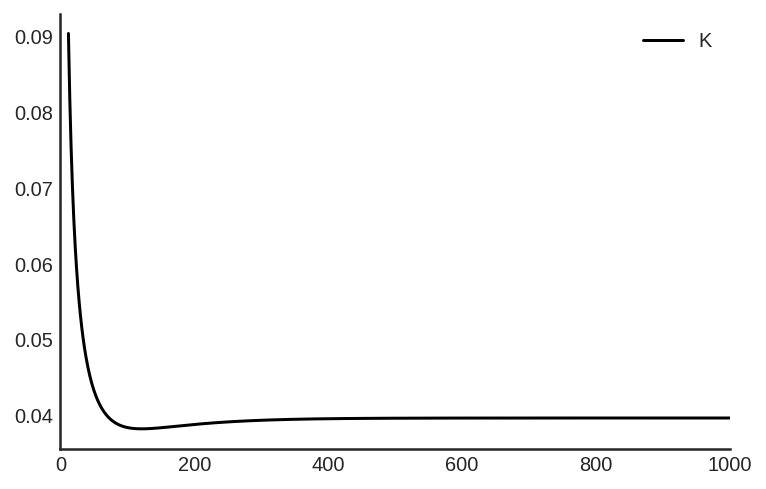

In [7]:
fig, ax = plt.subplots()

df[["K"]].pct_change().rolling(12).mean().plot(ax=ax, color='black')
sns.despine()
plt.show()

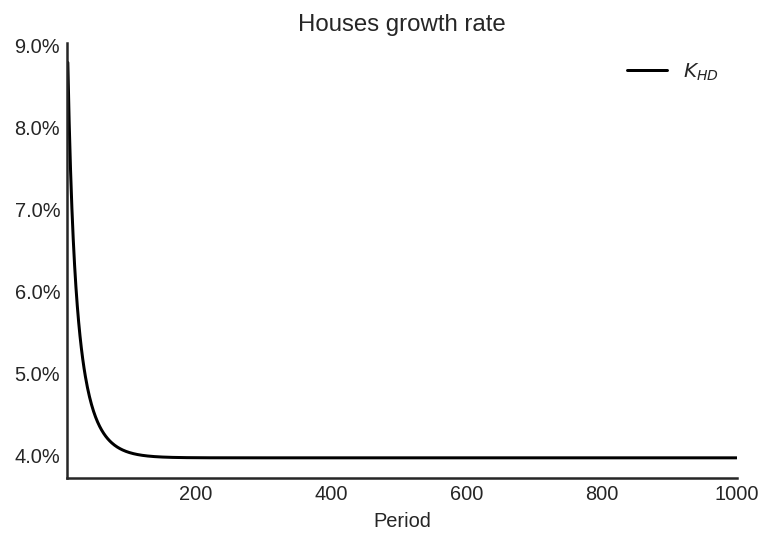

In [8]:
ax = df['K_HD'][10:].pct_change().plot(color="black",
                                       title="Houses growth rate",
                                       label="$K_{HD}$",
                                       legend=True)
ax.set_yticklabels(['{:,.1%}'.format(x) for x in ax.get_yticks()])
plt.xlabel("Period")
sns.despine()
plt.show()

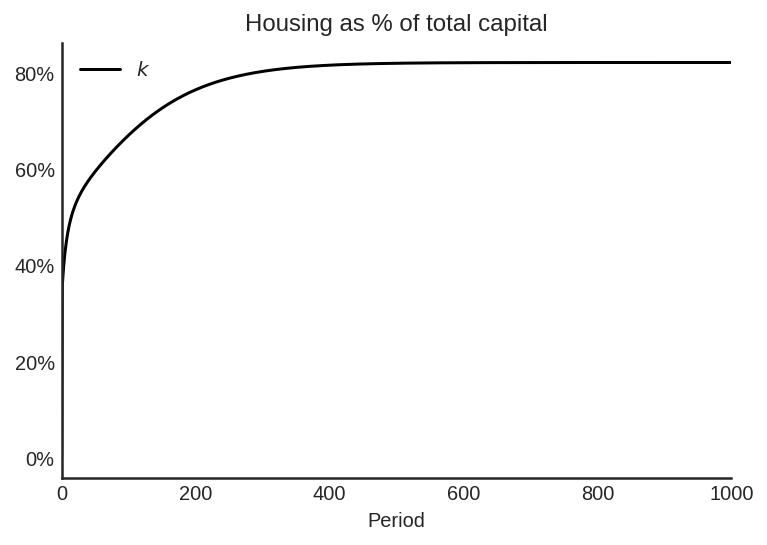

In [9]:
ax = df['K_k'].plot(color = "black", title = "Housing as % of total capital", label = "$k$", legend = True)
ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
plt.xlabel("Period")
sns.despine()
plt.show()

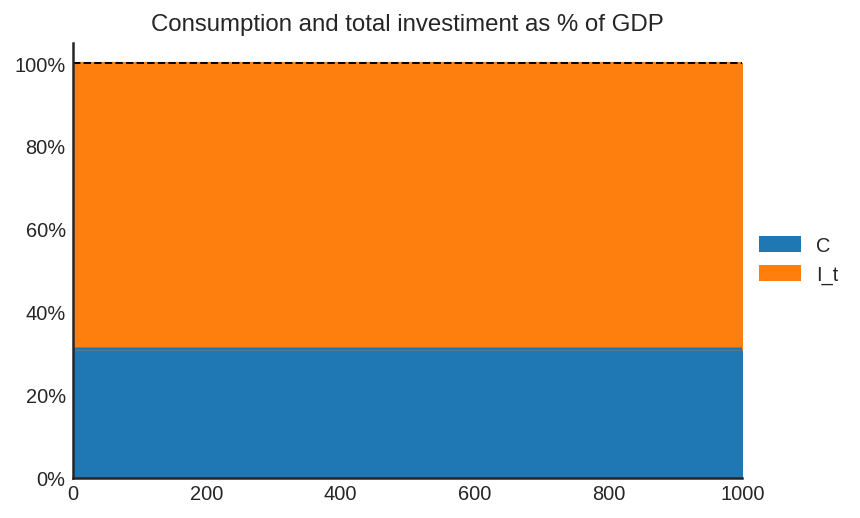

In [10]:
ax = df[['C', 'I_t']].apply(lambda x: x/df['Y']).plot(kind = 'area', stacked = True, legend = True, title = "Consumption and total investiment as % of GDP")
ax.axhline(y=1, color = "black", ls = "--", lw=1)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
sns.despine()
plt.show()

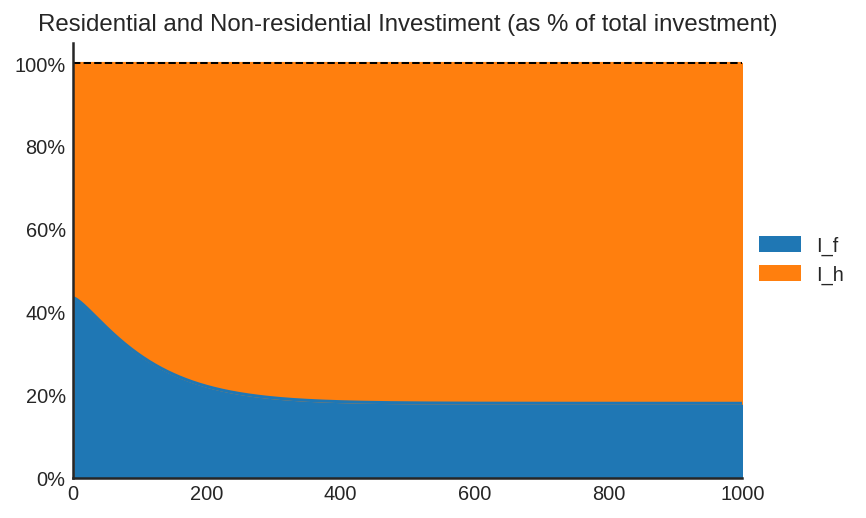

In [11]:
ax = df[['I_f', 'I_h']].apply(lambda x: x/df['I_t']).plot(kind = 'area', stacked = True, legend = True, title = "Residential and Non-residential Investiment (as % of total investment)")
ax.axhline(y=1, color = "black", ls = "--", lw=1)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
sns.despine()
plt.show()

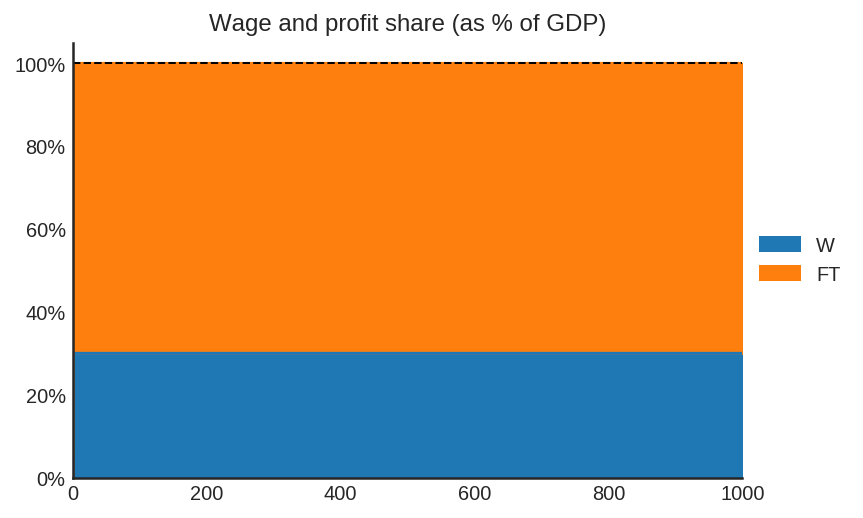

In [12]:
ax = df[['W', 'FT']].apply(lambda x: x/df['Y']).plot(kind = 'area', stacked = True, legend = True, title = "Wage and profit share (as % of GDP)")
ax.axhline(y=1, color = "black", ls = "--", lw=1)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
sns.despine()
plt.show()

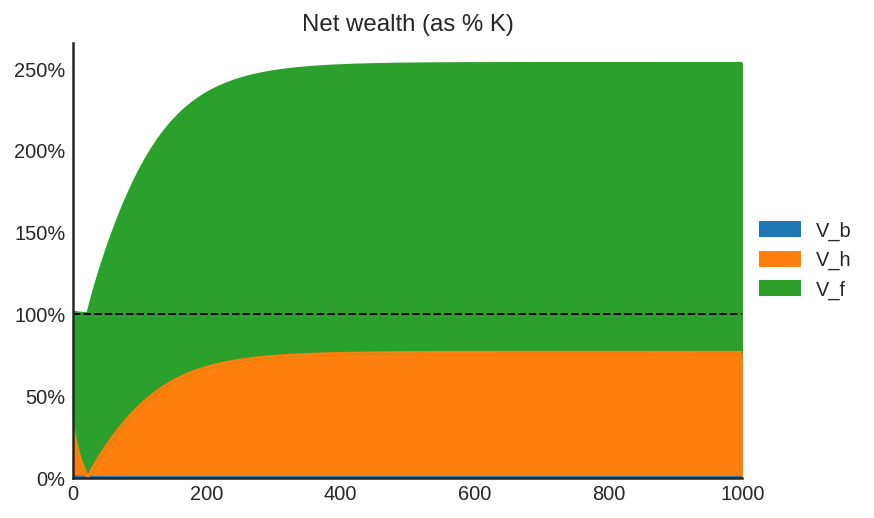

In [13]:
ax = df[['V_b', 'V_h', 'V_f']].apply(lambda x: np.abs(x)/df['K']).plot(kind = 'area', stacked = True, title = "Net wealth (as % K)")
ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
ax.axhline(y=1, color = "black", ls = "--", lw=1)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
sns.despine()
plt.show()

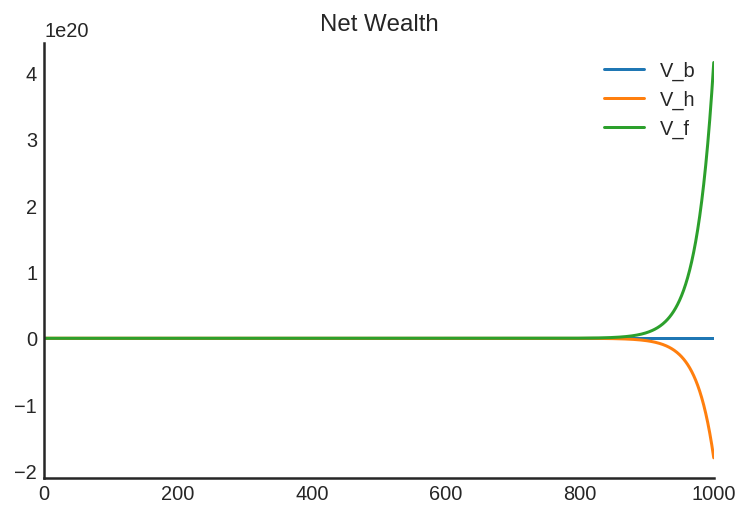

In [14]:
df[["V_b", "V_h", "V_f"]].plot(title = "Net Wealth")
sns.despine()
plt.show()

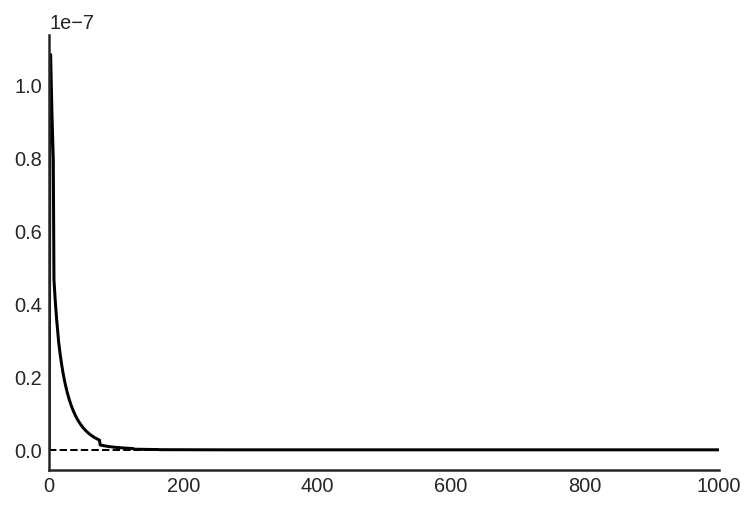

In [15]:
ax = ((df['V_b'] + df['V_f'] + df['V_h'] - df['K'])/df['K']).plot(label='Consistensy check', color='black')
ax.axhline(y=0, color = "black", ls = "--", lw=1)
sns.despine()
plt.show()

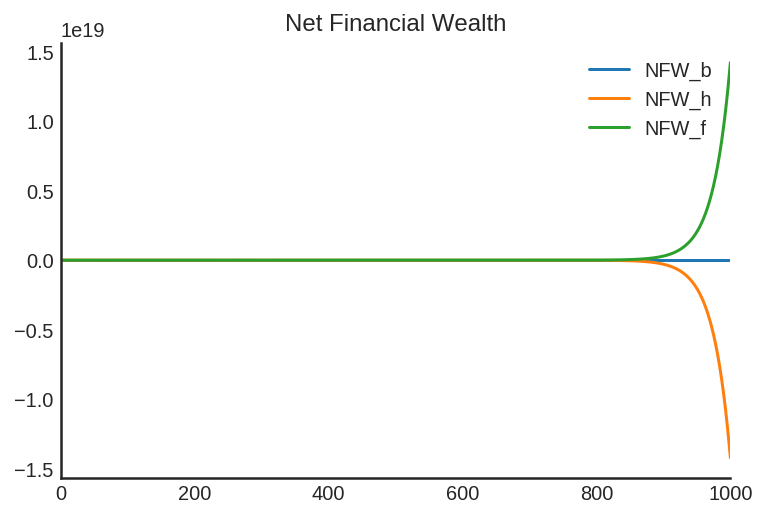

In [16]:
df[["NFW_b", "NFW_h", "NFW_f"]].plot(title = "Net Financial Wealth")
sns.despine()
plt.show()

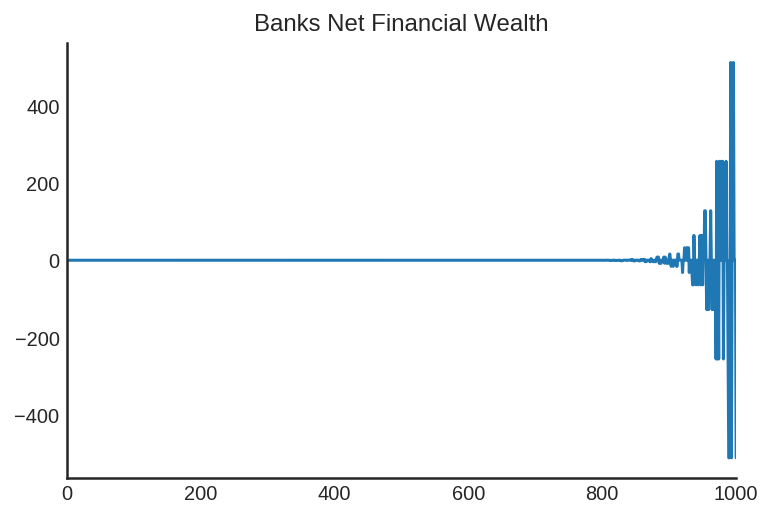

In [17]:
df['NFW_b'].plot(title = "Banks Net Financial Wealth")
sns.despine()
plt.show()

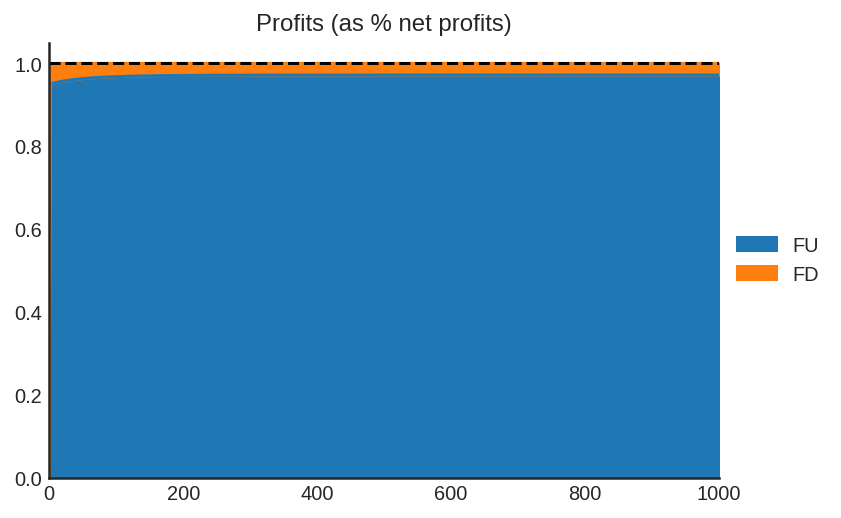

In [18]:
ax = df[["FU", "FD"]].apply(lambda x: x/df["Fn"]).plot(kind = "area", stacked = True, title = "Profits (as % net profits)")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.axhline(y = 1, color = "black", ls = "--")
sns.despine()
plt.show()

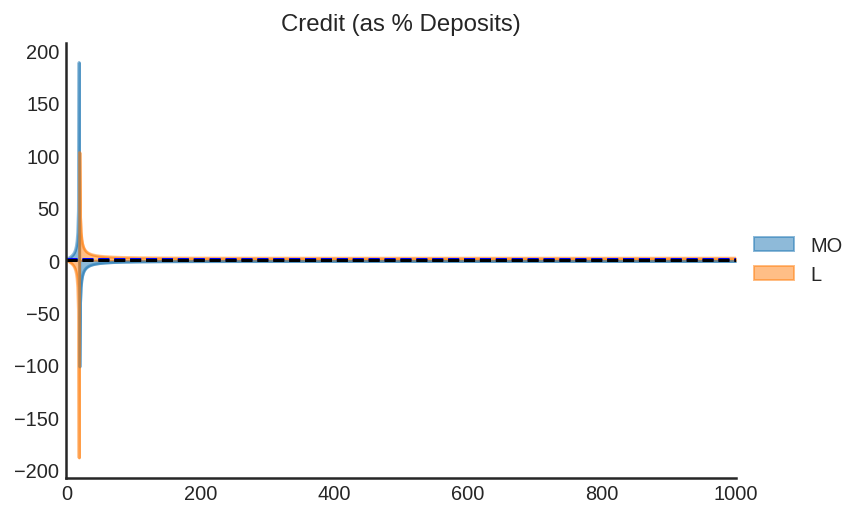

In [19]:
ax = df[["MO", "L"]].apply(lambda x: x/df["M"]).plot(kind = "area",stacked = False ,title = "Credit (as % Deposits)")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.axhline(y = 1, color = "blue", ls = "--")
ax.axhline(y = 0, color = "black", ls = "--")
sns.despine()
plt.show()

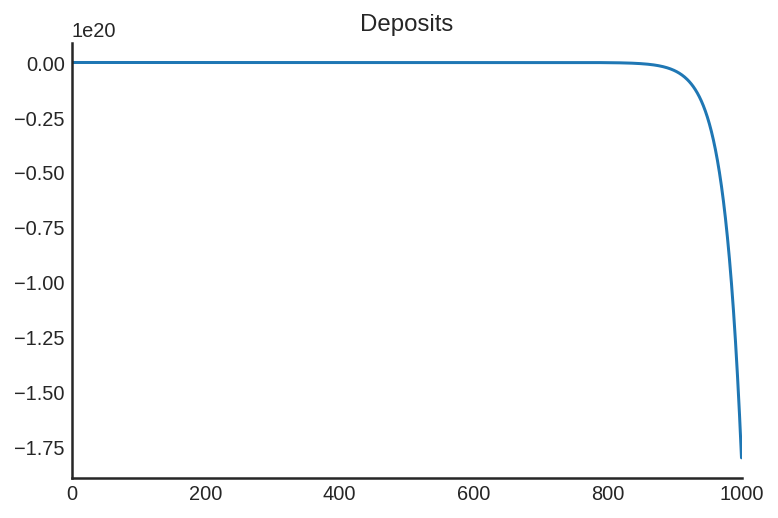

In [20]:
df["M"].plot(title = "Deposits")
sns.despine()
plt.show()

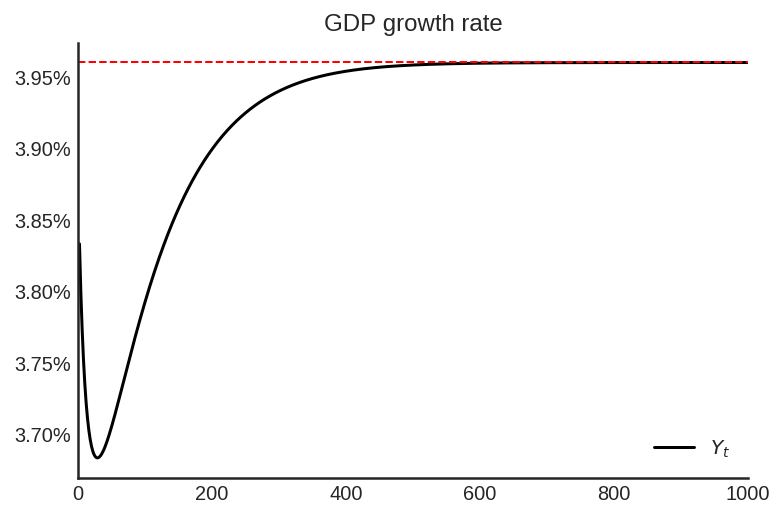

In [21]:
ax = df['Y'].pct_change().plot(color = "black", title = "GDP growth rate", label = "$Y_t$", legend = True)
ax.set_yticklabels(['{:,.2%}'.format(x) for x in ax.get_yticks()])
ax.axhline(y=df["g_Z"].iloc[-1], color = "red", ls = "--", lw=1, label = "Autonomous growth rate")
sns.despine()
plt.show()

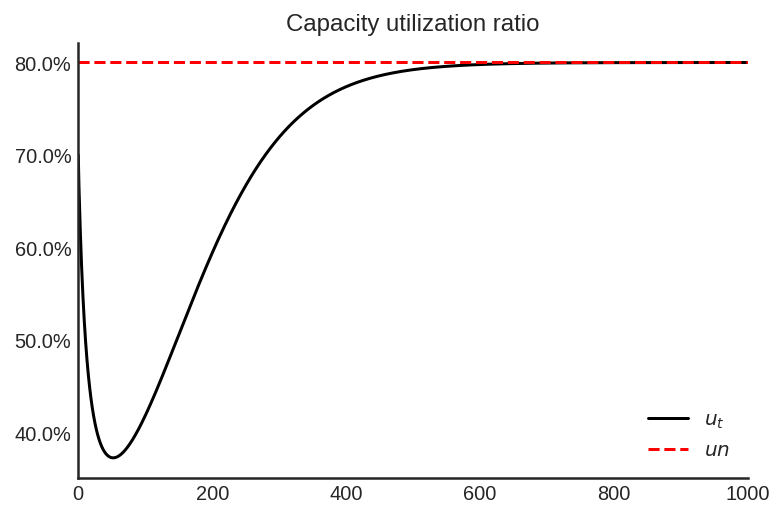

In [22]:
ax = df['u'].plot(color = "black", title = "Capacity utilization ratio", label = "$u_t$", legend = True)
ax.set_yticklabels(['{:,.1%}'.format(x) for x in ax.get_yticks()])
ax = df['un'].plot(color = "red", ls="--",  title = "Capacity utilization ratio", label = "$un$", legend = True)
ax.set_yticklabels(['{:,.1%}'.format(x) for x in ax.get_yticks()])
sns.despine()
plt.show()

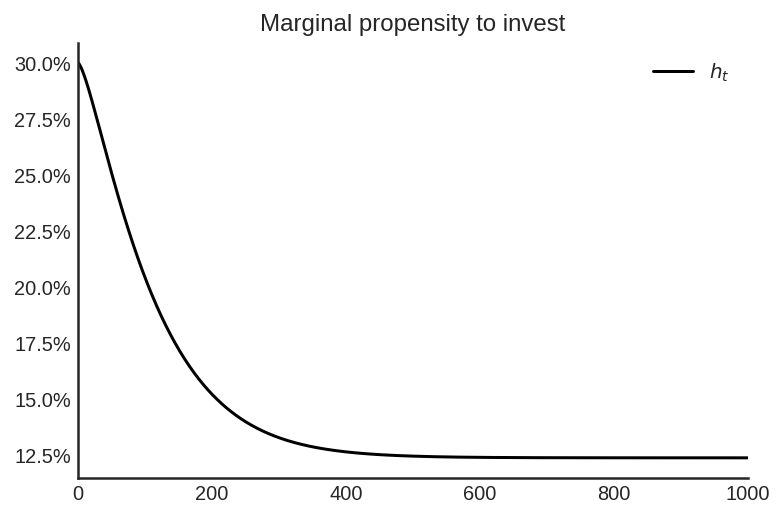

In [23]:
ax = df['h'].plot(color = "black", ls="-",  title = "Marginal propensity to invest", label = "$h_t$", legend = True)
ax.set_yticklabels(['{:,.1%}'.format(x) for x in ax.get_yticks()])
sns.despine()
plt.show()

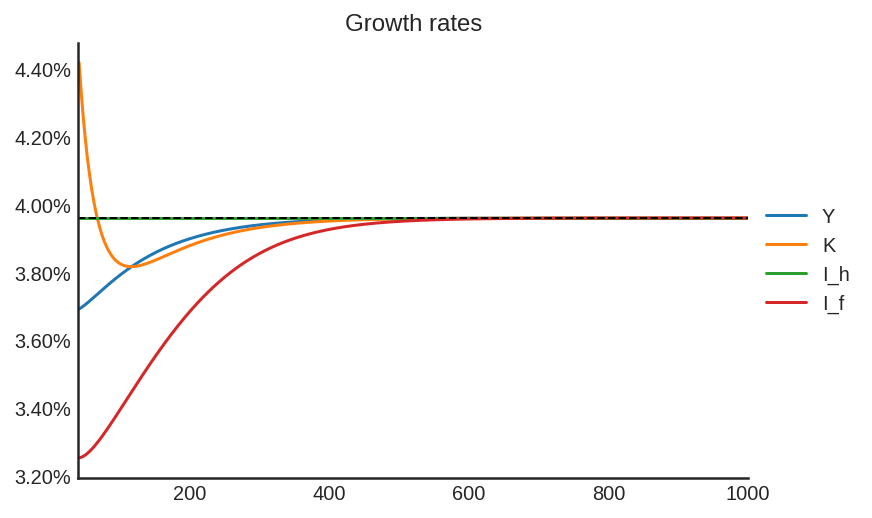

In [24]:
ax = df[["Y", "K", "I_h", "I_f"]][40:].pct_change().plot(title = "Growth rates")
ax.set_yticklabels(['{:,.2%}'.format(x) for x in ax.get_yticks()])
ax.axhline(y=df["g_Z"].iloc[-1], color = "black", ls = "--", lw=1)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
sns.despine()
plt.show()

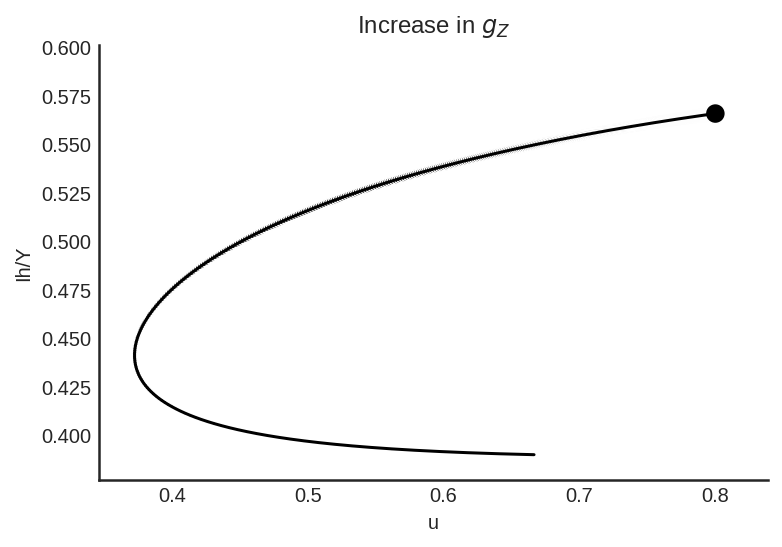

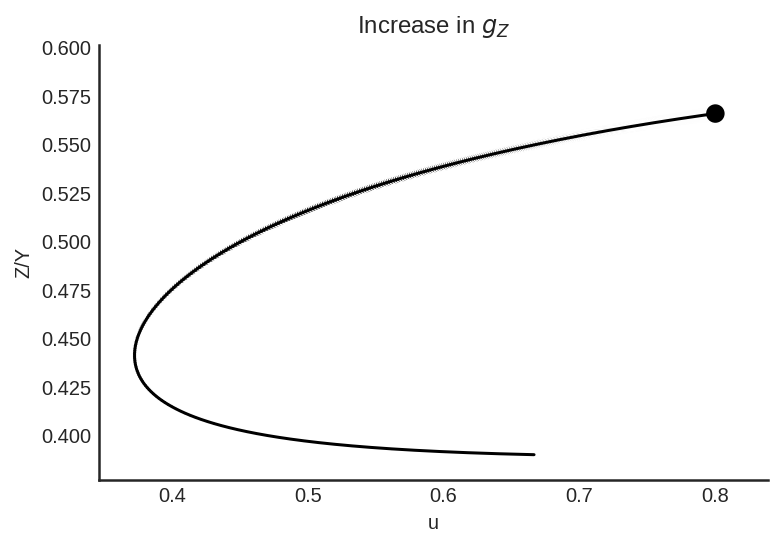

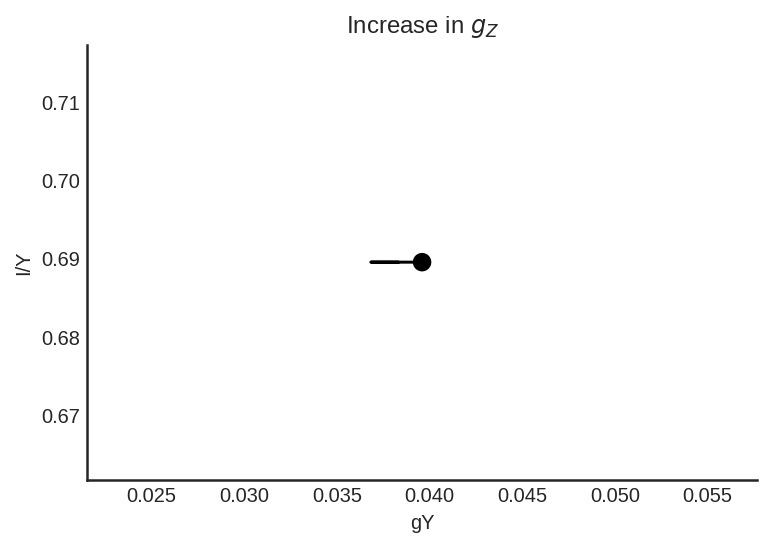

In [25]:
df["TIME"] = [i+1 for i in range(len(df.index))]
df["Ih/Y"] = df["I_h"]/df["Y"]
df["I/Y"] = df["I_t"]/df["Y"]
df["Z/Y"] = df["Z"]/df["Y"]
df["gY"] = df["Y"].pct_change()

sns.scatterplot(y = 'Ih/Y', x='u', data=df, size="TIME", sizes = (1,100), color = 'black', legend=False)
sns.lineplot(y = 'Ih/Y', x='u', data=df, sort=False, color = 'black')
plt.title('Increase in $g_Z$')
sns.despine()
plt.show()

sns.scatterplot(y = 'Z/Y', x='u', data=df, size="TIME", sizes = (1,100), color = 'black', legend=False)
sns.lineplot(y = 'Z/Y', x='u', data=df, sort=False, color = 'black')
plt.title('Increase in $g_Z$')
sns.despine()
plt.show()

sns.scatterplot(y = 'I/Y', x='gY', data=df, size="TIME", sizes = (1,100), color = 'black', legend=False)
sns.lineplot(y = 'I/Y', x='gY', data=df, sort=False, color = 'black')
plt.title('Increase in $g_Z$')
sns.despine()
plt.show()

# Shocks

In [26]:
def plot_shock(filename, shock):
    """
    This function plots some selected variables
    
    filename: name to save the plot (str)
    shock: df returned by ShockModel function
    """
    sns.set_context('paper')
    fig, ax = plt.subplots(2,2)

    shock[["Y"]].pct_change().plot(title = "Growth rates", ax = ax[0,0], 
                                                      ls = ('--'),
                                                      )
    shock[["K"]].pct_change().plot(title = "Growth rates", ax = ax[0,0], 
                                                      ls = (':'),
                                                      )
    shock[["I_h"]].pct_change().plot(title = "Growth rates", ax = ax[0,0], 
                                                      ls = ('-'),
                                                      )
    shock[["I_f"]].pct_change().plot(title = "Growth rates", ax = ax[0,0], 
                                                      ls = ('-.'),
                                                      )
    ax[0,0].axhline(y=shock["g_Z"].iloc[-1], color = "black", ls = "--", lw=1)
    #ax[0,0].set_yticklabels(['{:,.1%}'.format(x) for x in ax[0,0].get_yticks()])
    ax[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.06),
                   labels = ["$Y$", "$K$", "$I_h$", "$I_f$"],
              fancybox=True, shadow=True, ncol=2)
    ax[0,0].ticklabel_format(useOffset=False)

    shock['K_k'].plot(color = "darkred", title = "Houses \nas % of Total capital", label = "$\k$", legend = False, ax = ax[0,1], lw = 3, )
    ax[0,1].axhline(y = df['K_k'].iloc[-1], ls ='--', color = "gray")
    ax[0,1].ticklabel_format(useOffset=False)


    shock['u'].plot(title = 'Capacity utilization ratio', ax=ax[1,0], legend = False, color = "darkred", lw = 3, )
    ax[1,0].axhline(y = shock['un'].iloc[-1], ls ='--', color = "gray")
    #ax[1,0].set_yticklabels(['{:,.2%}'.format(x) for x in ax[1,0].get_yticks()])
    ax[1,0].ticklabel_format(useOffset=False)

    shock['h'].plot(title = 'Marginal propensity to invest', ax=ax[1,1], legend = False, color = "darkred", lw = 3, )
    ax[1,1].axhline(y = df['h'].iloc[-1], ls ='--', color = "gray")
    ax[1,1].ticklabel_format(useOffset=False)
    
    sns.despine()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    fig.savefig(filename, dpi = 300)

## Increase in autonomous growth rate ($g_z$)

In [27]:
base = model()
df = SolveSFC(base, time=900)
shock = ShockModel(base_model=base, create_function=model(), variable='phi_0', increase=0.01, time = 1200)
shock.transpose()

,0,1,2,3,4,5,6,7,8,9,...,1241,1242,1243,1244,1245,1246,1247,1248,1249,1250
C,8.300119e+16,8.628803e+16,8.970502e+16,9.325733e+16,9.695031e+16,1.007895e+17,1.047808e+17,1.089301e+17,1.132437e+17,1.177282e+17,...,6.705685e+42,7.038287e+42,7.387386e+42,7.753801e+42,8.138389e+42,8.542053e+42,8.965739e+42,9.410440e+42,9.877197e+42,1.036711e+43
C_w,8.019438e+16,8.337007e+16,8.667152e+16,9.010370e+16,9.367180e+16,9.738119e+16,1.012375e+17,1.052465e+17,1.094142e+17,1.137470e+17,...,6.478923e+42,6.800277e+42,7.137571e+42,7.491595e+42,7.863178e+42,8.253191e+42,8.662550e+42,9.092212e+42,9.543186e+42,1.001653e+43
C_k,2.806803e+15,2.917953e+15,3.033503e+15,3.153630e+15,3.278513e+15,3.408342e+15,3.543312e+15,3.683627e+15,3.829498e+15,3.981146e+15,...,2.267623e+41,2.380097e+41,2.498150e+41,2.622058e+41,2.752112e+41,2.888617e+41,3.031892e+41,3.182274e+41,3.340115e+41,3.505785e+41
FD,9.356012e+15,9.726509e+15,1.011168e+16,1.051210e+16,1.092838e+16,1.136114e+16,1.181104e+16,1.227876e+16,1.276499e+16,1.327049e+16,...,7.558743e+41,7.933657e+41,8.327166e+41,8.740194e+41,9.173707e+41,9.628723e+41,1.010631e+42,1.060758e+42,1.113372e+42,1.168595e+42
Fn,3.347556e+17,3.480119e+17,3.617932e+17,3.761202e+17,3.910145e+17,4.064987e+17,4.225960e+17,4.393308e+17,4.567283e+17,4.748147e+17,...,2.255949e+43,2.367844e+43,2.485290e+43,2.608560e+43,2.737944e+43,2.873747e+43,3.016284e+43,3.165892e+43,3.322920e+43,3.487737e+43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
_h__1,1.237546e-01,1.237546e-01,1.237545e-01,1.237545e-01,1.237544e-01,1.237544e-01,1.237543e-01,1.237542e-01,1.237542e-01,1.237541e-01,...,1.549999e-01,1.549999e-01,1.549999e-01,1.549999e-01,1.549999e-01,1.549999e-01,1.549999e-01,1.549999e-01,1.549999e-01,1.549999e-01
_L__1,-7.674088e+18,-7.674088e+18,-7.977982e+18,-8.293911e+18,-8.622350e+18,-8.963795e+18,-9.318761e+18,-9.687784e+18,-1.007142e+19,-1.047025e+19,...,-3.721004e+44,-3.905565e+44,-4.099281e+44,-4.302606e+44,-4.516015e+44,-4.740009e+44,-4.975114e+44,-5.221879e+44,-5.480885e+44,-5.752737e+44
_K_HD__1,3.970222e+18,3.970222e+18,4.127443e+18,4.290890e+18,4.460809e+18,4.637457e+18,4.821101e+18,5.012016e+18,5.210492e+18,5.416827e+18,...,2.327275e+44,2.442708e+44,2.563866e+44,2.691034e+44,2.824509e+44,2.964604e+44,3.111649e+44,3.265987e+44,3.427980e+44,3.598007e+44
_I_h__1,1.512320e+17,1.512320e+17,1.572208e+17,1.634467e+17,1.699192e+17,1.766480e+17,1.836433e+17,1.909156e+17,1.984758e+17,2.063355e+17,...,1.099779e+43,1.154328e+43,1.211583e+43,1.271677e+43,1.334753e+43,1.400956e+43,1.470444e+43,1.543378e+43,1.619929e+43,1.700278e+43


In [28]:
summary = SummaryShock(shock)
summary

,0,Shock,1,2,3,t-1,t,difference
C,5.786237e+17,6.073336e+17,6.374785e+17,6.691303e+17,7.023646e+17,9.877197e+42,1.036711e+43,4.899090e+41
C_w,5.590567e+17,5.867957e+17,6.159213e+17,6.465027e+17,6.786131e+17,9.543186e+42,1.001653e+43,4.733420e+41
C_k,1.956698e+16,2.053785e+16,2.155724e+16,2.262760e+16,2.375146e+16,3.340115e+41,3.505785e+41,1.656697e+40
FD,6.522328e+16,6.845950e+16,7.185748e+16,7.542532e+16,7.917153e+16,1.113372e+42,1.168595e+42,5.522324e+40
Fn,2.333676e+18,2.439158e+18,2.549690e+18,2.665520e+18,2.786910e+18,3.322920e+43,3.487737e+43,1.648169e+42
...,...,...,...,...,...,...,...,...
_h__1,1.237524e-01,1.237524e-01,1.237619e-01,1.237807e-01,1.238085e-01,1.549999e-01,1.549999e-01,8.391919e-10
_L__1,-5.146054e+19,-5.349837e+19,-5.562699e+19,-5.785070e+19,-6.017398e+19,-5.480885e+44,-5.752737e+44,-2.718519e+43
_K_HD__1,2.662331e+19,2.767760e+19,2.878417e+19,2.994563e+19,3.116470e+19,3.427980e+44,3.598007e+44,1.700278e+43
_I_h__1,1.014124e+18,1.054283e+18,1.106576e+18,1.161462e+18,1.219070e+18,1.619929e+43,1.700278e+43,8.034850e+41


In [29]:
shock1 = shock.round(decimals = 5).tail(1).transpose().loc['alpha':,:]
shock1.columns = ['$\Delta \phi_0$']
shock1

,$\Delta \phi_0$
alpha,1.000000e+00
alpha_2,3.000000e-01
gamma_F,9.500000e-01
gamma_u,1.000000e-02
omega,3.000000e-01
rm,2.000000e-02
spread_l,0.000000e+00
spread_mo,0.000000e+00
un,8.000000e-01
v,2.500000e+00


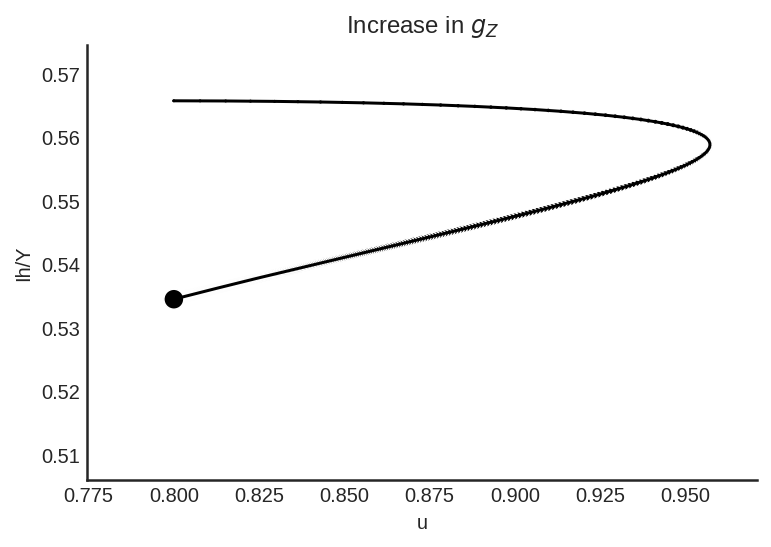

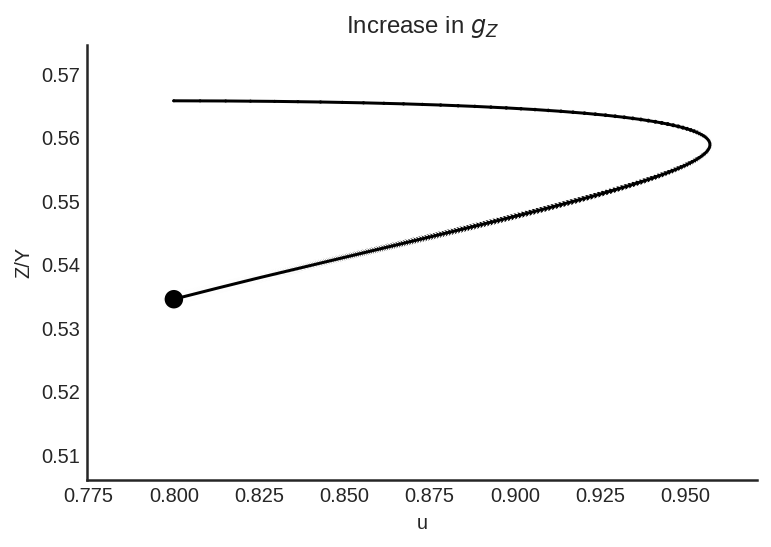

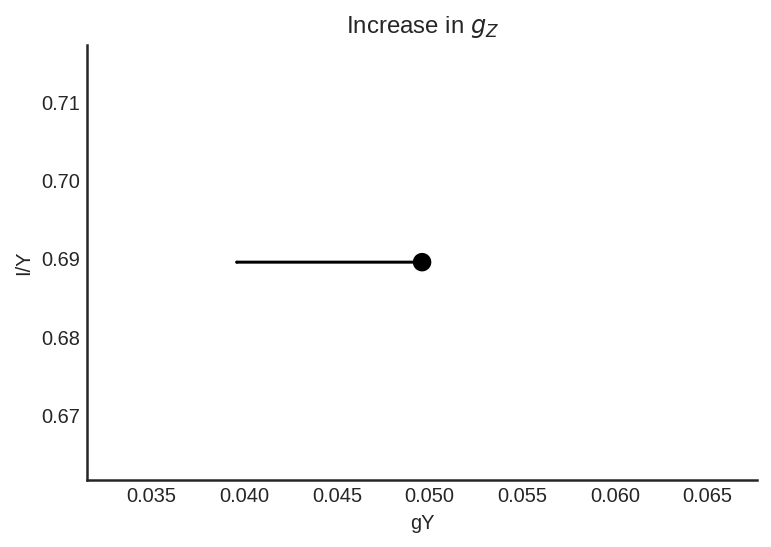

In [30]:
shock["TIME"] = [i+1 for i in range(len(shock.index))]
shock["Ih/Y"] = shock["I_h"]/shock["Y"]
shock["I/Y"] = shock["I_t"]/shock["Y"]
shock["Z/Y"] = shock["Z"]/shock["Y"]
shock["gY"] = shock["Y"].pct_change()

sns.scatterplot(y = 'Ih/Y', x='u', data=shock, size="TIME", sizes = (1,100), color = 'black', legend=False)
sns.lineplot(y = 'Ih/Y', x='u', data=shock, sort=False, color = 'black')
plt.title('Increase in $g_Z$')
sns.despine()
plt.show()

sns.scatterplot(y = 'Z/Y', x='u', data=shock, size="TIME", sizes = (1,100), color = 'black', legend=False)
sns.lineplot(y = 'Z/Y', x='u', data=shock, sort=False, color = 'black')
plt.title('Increase in $g_Z$')
sns.despine()
plt.show()

sns.scatterplot(y = 'I/Y', x='gY', data=shock, size="TIME", sizes = (1,100), color = 'black', legend=False)
sns.lineplot(y = 'I/Y', x='gY', data=shock, sort=False, color = 'black')
plt.title('Increase in $g_Z$')
sns.despine()
plt.show()

### Plots

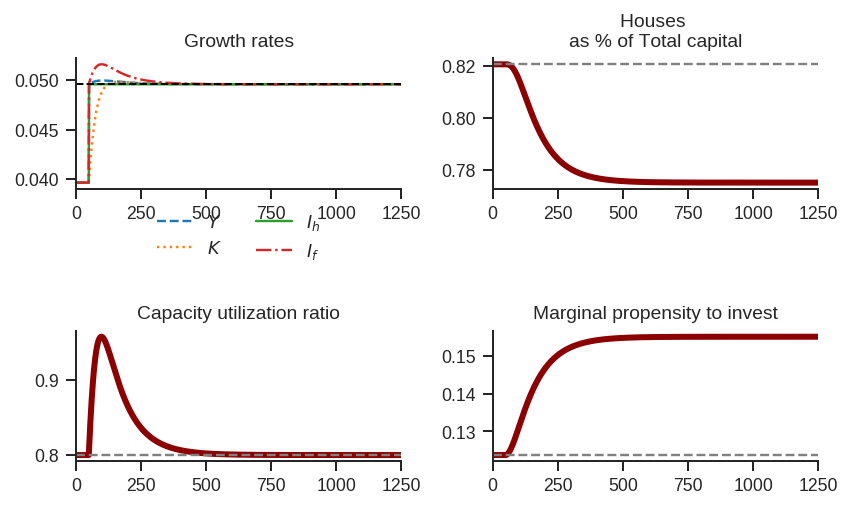

In [31]:
plot_shock(shock = shock, filename = 'Shock_1.png')

## Decrease in wage-share ($\omega$)

In [32]:
base = model()
df = SolveSFC(base, time=700)
shock = ShockModel(base_model=base, create_function=model(), variable='omega', increase=-0.05, time = 900)
shock.transpose()

,0,1,2,3,4,5,6,7,8,9,...,941,942,943,944,945,946,947,948,949,950
C,3.514570e+13,3.653742e+13,3.798425e+13,3.948838e+13,4.105206e+13,4.267767e+13,4.436765e+13,4.612455e+13,4.795103e+13,4.984983e+13,...,2.021769e+29,2.101831e+29,2.185064e+29,2.271592e+29,2.361547e+29,2.455065e+29,2.552285e+29,2.653356e+29,2.758428e+29,2.867662e+29
C_w,3.395720e+13,3.530185e+13,3.669976e+13,3.815302e+13,3.966383e+13,4.123446e+13,4.286730e+13,4.456479e+13,4.632949e+13,4.816408e+13,...,1.934707e+29,2.011322e+29,2.090970e+29,2.173772e+29,2.259854e+29,2.349344e+29,2.442378e+29,2.539096e+29,2.639644e+29,2.744174e+29
C_k,1.188502e+12,1.235565e+12,1.284492e+12,1.335356e+12,1.388234e+12,1.443206e+12,1.500355e+12,1.559768e+12,1.621532e+12,1.685743e+12,...,8.706183e+27,9.050947e+27,9.409365e+27,9.781976e+27,1.016934e+28,1.057205e+28,1.099070e+28,1.142593e+28,1.187840e+28,1.234878e+28
FD,3.961673e+12,4.118550e+12,4.281639e+12,4.451186e+12,4.627447e+12,4.810688e+12,5.001185e+12,5.199225e+12,5.405108e+12,5.619143e+12,...,2.902061e+28,3.016982e+28,3.136455e+28,3.260659e+28,3.389781e+28,3.524016e+28,3.663567e+28,3.808644e+28,3.959467e+28,4.116262e+28
Fn,1.417407e+14,1.473535e+14,1.531886e+14,1.592548e+14,1.655611e+14,1.721172e+14,1.789330e+14,1.860186e+14,1.933848e+14,2.010428e+14,...,1.045334e+30,1.086729e+30,1.129764e+30,1.174503e+30,1.221013e+30,1.269365e+30,1.319632e+30,1.371889e+30,1.426216e+30,1.482694e+30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
_h__1,1.238093e-01,1.238093e-01,1.238086e-01,1.238078e-01,1.238071e-01,1.238064e-01,1.238057e-01,1.238050e-01,1.238043e-01,1.238036e-01,...,1.237499e-01,1.237499e-01,1.237499e-01,1.237499e-01,1.237499e-01,1.237499e-01,1.237499e-01,1.237499e-01,1.237499e-01,1.237499e-01
_L__1,-3.249125e+15,-3.249125e+15,-3.377791e+15,-3.511552e+15,-3.650610e+15,-3.795175e+15,-3.945465e+15,-4.101706e+15,-4.264134e+15,-4.432995e+15,...,-2.324610e+31,-2.416665e+31,-2.512365e+31,-2.611855e+31,-2.715284e+31,-2.822809e+31,-2.934592e+31,-3.050802e+31,-3.171614e+31,-3.297210e+31
_K_HD__1,1.680973e+15,1.680973e+15,1.747539e+15,1.816742e+15,1.888685e+15,1.963477e+15,2.041230e+15,2.122063e+15,2.206097e+15,2.293458e+15,...,1.201864e+31,1.249458e+31,1.298936e+31,1.350374e+31,1.403849e+31,1.459441e+31,1.517235e+31,1.577318e+31,1.639779e+31,1.704715e+31
_I_h__1,6.403090e+13,6.403090e+13,6.656652e+13,6.920255e+13,7.194297e+13,7.479192e+13,7.775368e+13,8.083272e+13,8.403370e+13,8.736143e+13,...,4.578088e+29,4.759381e+29,4.947852e+29,5.143787e+29,5.347481e+29,5.559241e+29,5.779387e+29,6.008251e+29,6.246178e+29,6.493526e+29


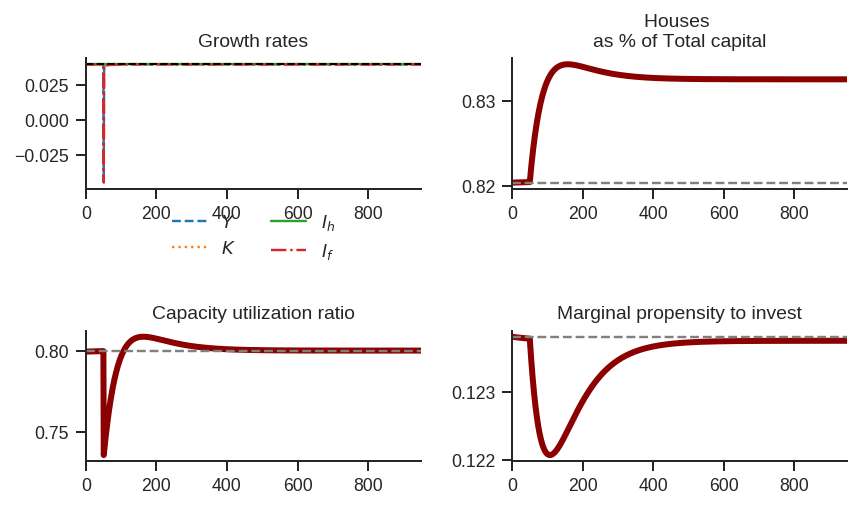

In [33]:
plot_shock(shock = shock, filename = 'Shock_2.png')

In [34]:
shock2 = shock.round(decimals = 3).tail(1).transpose().loc['alpha':,:]
shock2.columns = ['$\Delta \omega$']
shock2

,$\Delta \omega$
alpha,1.000000e+00
alpha_2,3.000000e-01
gamma_F,9.500000e-01
gamma_u,1.000000e-02
omega,2.500000e-01
rm,2.000000e-02
spread_l,0.000000e+00
spread_mo,0.000000e+00
un,8.000000e-01
v,2.500000e+00


## Increase in interest rates

In [35]:
base = model()
df = SolveSFC(base, time=1000)
shock = ShockModel(base_model=base, create_function=model(), variable='spread_mo', increase=0.005, time = 1000)
shock.transpose()

,0,1,2,3,4,5,6,7,8,9,...,1041,1042,1043,1044,1045,1046,1047,1048,1049,1050
C,4.033749e+18,4.193485e+18,4.359547e+18,4.532185e+18,4.711659e+18,4.898241e+18,5.092211e+18,5.293863e+18,5.503499e+18,5.721438e+18,...,1.323899e+36,1.376193e+36,1.430553e+36,1.487059e+36,1.545798e+36,1.606857e+36,1.670328e+36,1.736306e+36,1.804890e+36,1.876183e+36
C_w,3.897342e+18,4.051676e+18,4.212123e+18,4.378923e+18,4.552328e+18,4.732600e+18,4.920011e+18,5.114843e+18,5.317391e+18,5.527959e+18,...,1.279129e+36,1.329655e+36,1.382176e+36,1.436772e+36,1.493525e+36,1.552519e+36,1.613844e+36,1.677590e+36,1.743855e+36,1.812737e+36
C_k,1.364070e+17,1.418087e+17,1.474243e+17,1.532623e+17,1.593315e+17,1.656410e+17,1.722004e+17,1.790195e+17,1.861087e+17,1.934786e+17,...,4.476953e+34,4.653792e+34,4.837617e+34,5.028703e+34,5.227337e+34,5.433817e+34,5.648452e+34,5.871566e+34,6.103493e+34,6.344581e+34
FD,4.546899e+17,4.726956e+17,4.914143e+17,5.108743e+17,5.311049e+17,5.521367e+17,5.740013e+17,5.967317e+17,6.203622e+17,6.449286e+17,...,1.492318e+35,1.551264e+35,1.612539e+35,1.676234e+35,1.742446e+35,1.811272e+35,1.882817e+35,1.957189e+35,2.034498e+35,2.114860e+35
Fn,1.626873e+19,1.691297e+19,1.758273e+19,1.827900e+19,1.900285e+19,1.975536e+19,2.053768e+19,2.135097e+19,2.219647e+19,2.307545e+19,...,5.352938e+36,5.564379e+36,5.784172e+36,6.012646e+36,6.250146e+36,6.497027e+36,6.753659e+36,7.020429e+36,7.297736e+36,7.585996e+36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
_h__1,1.237513e-01,1.237513e-01,1.237513e-01,1.237512e-01,1.237512e-01,1.237512e-01,1.237512e-01,1.237512e-01,1.237512e-01,1.237511e-01,...,1.234375e-01,1.234375e-01,1.234375e-01,1.234375e-01,1.234375e-01,1.234375e-01,1.234375e-01,1.234375e-01,1.234375e-01,1.234375e-01
_L__1,-3.729531e+20,-3.729531e+20,-3.877221e+20,-4.030759e+20,-4.190377e+20,-4.356316e+20,-4.528826e+20,-4.708167e+20,-4.894611e+20,-5.088437e+20,...,-1.184151e+38,-1.230925e+38,-1.279547e+38,-1.330089e+38,-1.382627e+38,-1.437241e+38,-1.494012e+38,-1.553026e+38,-1.614370e+38,-1.678138e+38
_K_HD__1,1.929487e+20,1.929487e+20,2.005895e+20,2.085328e+20,2.167907e+20,2.253757e+20,2.343005e+20,2.435788e+20,2.532246e+20,2.632522e+20,...,6.110271e+37,6.351627e+37,6.602516e+37,6.863316e+37,7.134417e+37,7.416226e+37,7.709167e+37,8.013679e+37,8.330220e+37,8.659263e+37
_I_h__1,7.349721e+18,7.349721e+18,7.640770e+18,7.943344e+18,8.257900e+18,8.584913e+18,8.924876e+18,9.278301e+18,9.645722e+18,1.002769e+19,...,2.321844e+36,2.413557e+36,2.508893e+36,2.607994e+36,2.711010e+36,2.818095e+36,2.929409e+36,3.045121e+36,3.165403e+36,3.290437e+36


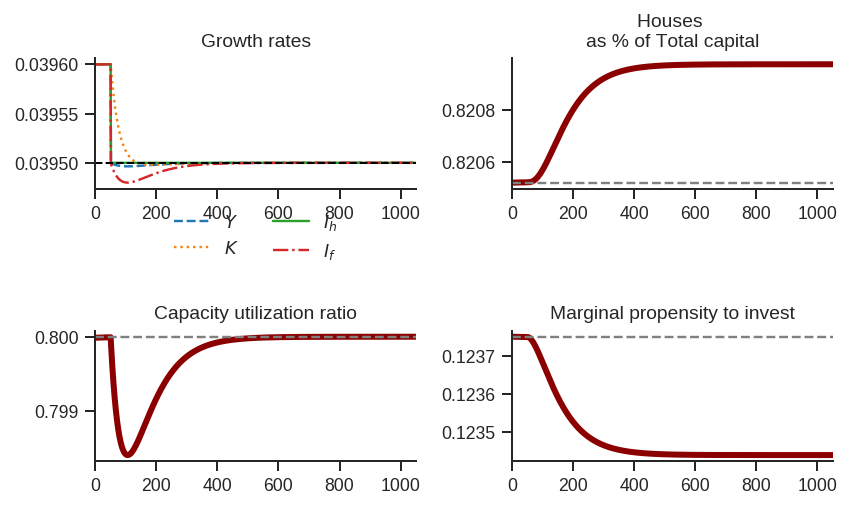

In [36]:
plot_shock(shock = shock, filename = 'Shock_3.png')

In [37]:
shock3 = shock.round(decimals = 3).tail(1).transpose().loc['alpha':,:]
shock3.columns = ['$\Delta rm$']
shock3

,$\Delta rm$
alpha,1.000000e+00
alpha_2,3.000000e-01
gamma_F,9.500000e-01
gamma_u,1.000000e-02
omega,3.000000e-01
rm,2.000000e-02
spread_l,0.000000e+00
spread_mo,5.000000e-03
un,8.000000e-01
v,2.500000e+00


## Increase in inflation

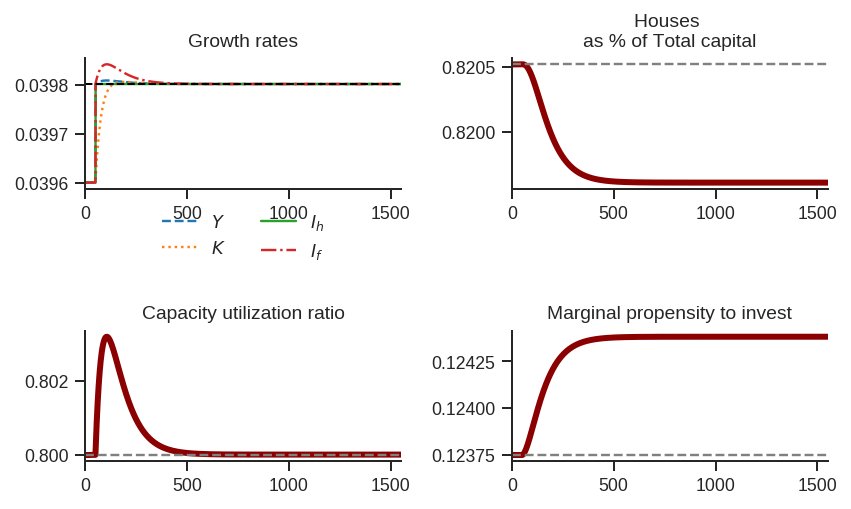

In [38]:
base = model()
df = SolveSFC(base, time=1000)
shock = ShockModel(base_model=base, create_function=model(), variable='infla', increase=0.01, time = 1500)

plot_shock(shock = shock, filename = 'Shock_4.png')

In [39]:
shock4 = shock.round(decimals = 3).tail(1).transpose().loc['alpha':,:]
shock4.columns = ['$\Delta $ Infla']
shock4

,$\Delta $ Infla
alpha,1.000000e+00
alpha_2,3.000000e-01
gamma_F,9.500000e-01
gamma_u,1.000000e-02
omega,3.000000e-01
rm,2.000000e-02
spread_l,0.000000e+00
spread_mo,0.000000e+00
un,8.000000e-01
v,2.500000e+00


## Plugging real data

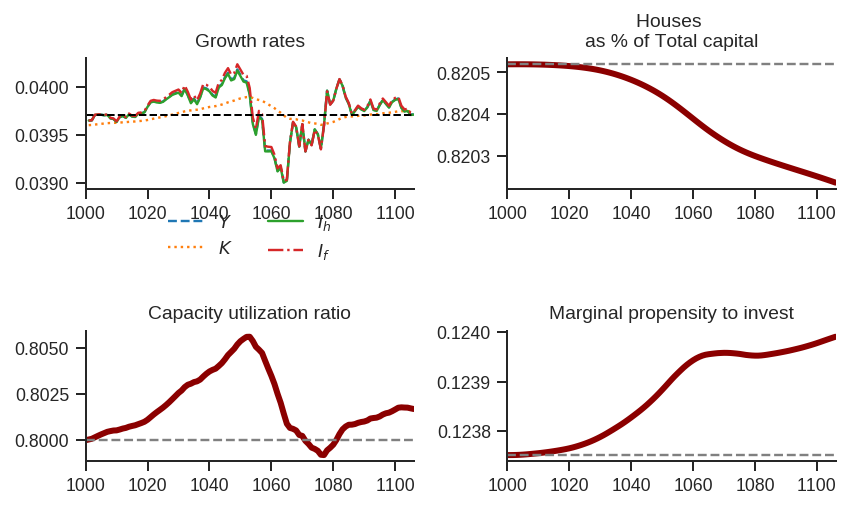

In [40]:
base=model()

initial=1000
shock_duration=1

SolveSFC(base, time=initial, table=False)

for i in data.index:
    lagged = [key for key in base.solutions[-1].keys()]
    lagged = [i for i in lagged if "__" in i]
    for j in lagged:
        del base.solutions[-1][j]
    base.set_values(base.solutions[-1])
    base.set_values({
            'own':data['Taxa Própria'][i],
            'infla':data['Inflação'][i],
        })
    try: 
        SolveSFC(base, time=shock_duration, table=False)
    except Exception as e:
        print(f'For own interest rate = {i}, {e}')
        pass
    
shock = SFCTable(base)[initial:]
plot_shock(shock = shock, filename = 'Shock_5.png')

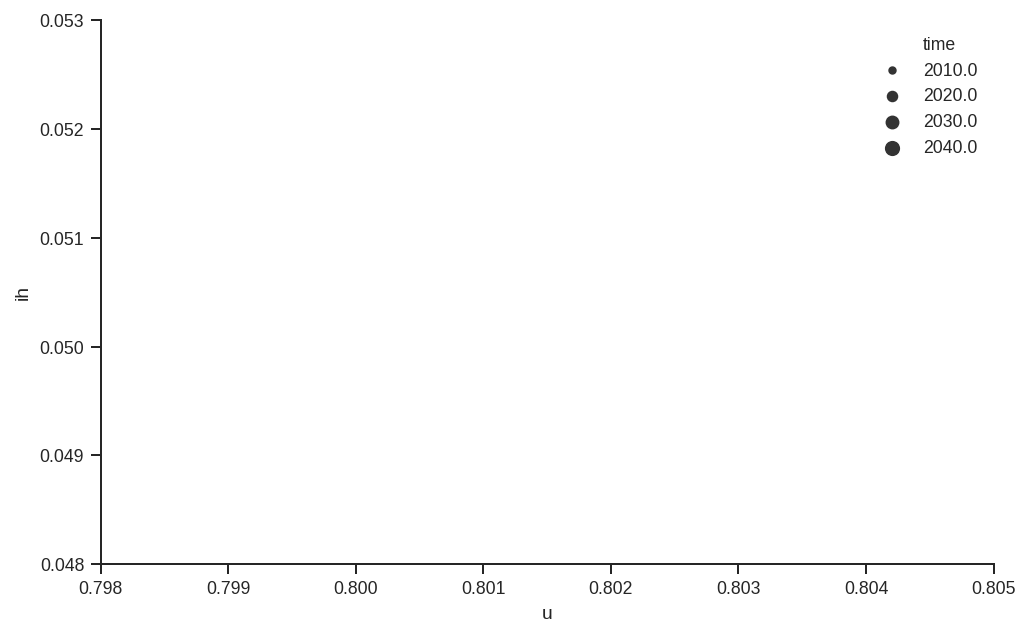

In [41]:
shock['ih'] = shock['I_h']/shock['Y']
shock['time'] = (shock.index/4) - shock.shape[0] + (1987 - 120)

cycle=int(shock.shape[0])

for i in range(0,shock.shape[0],cycle):

    fig, ax = plt.subplots(figsize=(8,5))

    sns.scatterplot(x='u', y='ih', data=shock[i:i+cycle], size='time', color='black')
    sns.lineplot(x = 'u', y='ih', data=shock[i:i+cycle], ax=ax, color = 'black', sort=False,)
    ax.set_xlim(.798,.805)
    ax.set_ylim(.048,.053)
    sns.despine()

# Merging tables

In [42]:
df = df.round(decimals = 3).tail(1).transpose().loc['alpha':,:]
df.columns = ['Base scenario']
df

table = pd.merge(left = df, right = shock1, left_index = True, right_index = True)
table = pd.merge(left = table, right = shock2, left_index = True, right_index = True)
table = pd.merge(left = table, right = shock3, left_index = True, right_index = True)
table = pd.merge(left = table, right = shock4, left_index = True, right_index = True)
table.to_latex("table.tex", bold_rows = True, column_format = 'c', decimal = ',', escape=False,)
table

,Base scenario,$\Delta \phi_0$,$\Delta \omega$,$\Delta rm$,$\Delta $ Infla
alpha,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
alpha_2,3.000000e-01,3.000000e-01,3.000000e-01,3.000000e-01,3.000000e-01
gamma_F,9.500000e-01,9.500000e-01,9.500000e-01,9.500000e-01,9.500000e-01
gamma_u,1.000000e-02,1.000000e-02,1.000000e-02,1.000000e-02,1.000000e-02
omega,3.000000e-01,3.000000e-01,2.500000e-01,3.000000e-01,3.000000e-01
rm,2.000000e-02,2.000000e-02,2.000000e-02,2.000000e-02,2.000000e-02
spread_l,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
spread_mo,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e-03,0.000000e+00
un,8.000000e-01,8.000000e-01,8.000000e-01,8.000000e-01,8.000000e-01
v,2.500000e+00,2.500000e+00,2.500000e+00,2.500000e+00,2.500000e+00


# Dag

/home/gpetrini/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/gpetrini/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


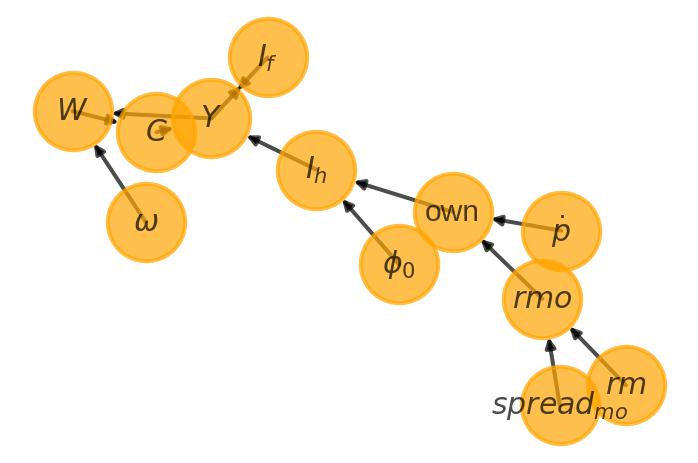

In [43]:
df = pd.DataFrame(
    {
        'Determinada' : [
            '$Y$', # 1
            #'$Y$', # 2
            '$C$', # 3
            '$W$', # 5
            '$Y$', # 7
            '$Y$', # 8
            '$I_h$', # 9
            'own', # 10
            'own', # 11
            '$I_f$', # 12
            '$I_h$', # 13
            '$rmo$', # 14
            '$rmo$', # 15,
            '$W$', # 16
        ], 
        'Determina' : [
            '$C$',  # 1
            #'$It$', # 2
            '$W$', # 3
            '$\omega$', # 5
            '$I_f$', # 7
            '$I_h$', # 8
            'own', # 9
            '$\dot p$', # 10
            '$rmo$', # 11
            '$Y$', # 12,
            '$\phi_0$', # 13
            '$rm$', # 14
            '$spread_{mo}$', # 15
            '$Y$', # 16
        ]
}
)
 
# Build your graph
G=nx.from_pandas_edgelist(
    df, 
    'Determina', 
    'Determinada', 
    create_using=nx.DiGraph() # To use with arrows
)
 
    
fig, ax = plt.subplots()
    
# Plot it
nx.draw(
    G, 
    with_labels=True, 
    node_color='orange', 
    node_size=1500, 
    edge_color='black', 
    linewidths=2,
    width=2,
    arrows=True,
    font_size=15,
    alpha=.7, 
    ax = ax,
    #pos=nx.spring_layout(G),
    pos=nx.fruchterman_reingold_layout(G),
    #pos=nx.shell_layout(G),
)

plt.show()
fig.savefig('Dag.png', dpi = 300)

# Analytical solution

In [44]:
base_eq = model()
SolveSFC(base_eq, time=1, table = False)
t = sp.Symbol('t')
initials = {
    key: base_eq.evaluate(key) for key in base_eq.parameters
}
initials.update({key: base_eq.evaluate(key) for key in base_eq.variables})

for i in base_eq.variables:
  globals()["_" + i] = sp.Function(i)
  
for i in base_eq.parameters:
  globals()[i] = sp.symbols(i, positive=True)
  globals()['infla'] = sp.symbols('infla')

## General equations

In [45]:
Y = _C(t) + _I_t(t)
pprint(sp.Eq(_Y(t), Y))
C = _C_w(t) + _C_k(t)
pprint(sp.Eq(_C(t), C))
I = _I_f(t) + _I_h(t)
pprint(sp.Eq(_I_t(t), I))
Yk = _K_f(t)/v
pprint(sp.Eq(_Yk(t), Yk))
u = _Y(t)/_Yk(t)
pprint(sp.Eq(_u(t), u))
Z = _I_h(t)
pprint(sp.Eq(_Z(t), Z))
W = omega*_Y(t)
pprint(sp.Eq(_W(t), W))
K = _K_HD(t) + _K_f(t)
pprint(sp.Eq(_K(t), K))

Y(t) = C(t) + Iₜ(t)
C(t) = Cₖ(t) + C_w(t)
Iₜ(t) = I_f(t) + Iₕ(t)
        K_f(t)
Yk(t) = ──────
          v   
        Y(t)
u(t) = ─────
       Yk(t)
Z(t) = Iₕ(t)
W(t) = ω⋅Y(t)
K(t) = K_HD(t) + K_f(t)


## Households

In [46]:
C_k = alpha_2*_FD(t)
pprint(sp.Eq(_C_w(t), C_k))
C_w = _W(t)
pprint(sp.Eq(_C_w(t), C_w))
YD_k =  _FD(t) + rm*_M(t-1) - _rmo(t)*_MO(t-1)
pprint(sp.Eq(_YD_k(t), YD_k))
Sh_k = _YD_k(t) - _C_k(t)
pprint(sp.Eq(_Sh_k(t), Sh_k))
YD_w =  _W(t)
pprint(sp.Eq(_YD_w(t), YD_w))
Sh_w = _YD_w(t) - _C_w(t)
pprint(sp.Eq(_Sh_w(t), Sh_w))
dMO = _I_h(t)
pprint(sp.Eq(_MO(t) - _MO(t-1), dMO))
V_h = _M(t) + _K_HD(t) - _MO(t)
pprint(sp.Eq(_V_h(t), V_h))
NFW_h = _Sh_k(t) - _I_h(t)
pprint(sp.Eq(_NFW_h(t), NFW_h))

C_w(t) = α₂⋅FD(t)
C_w(t) = W(t)
YDₖ(t) = rm⋅M(t - 1) + FD(t) - MO(t - 1)⋅rmo(t)
Shₖ(t) = -Cₖ(t) + YDₖ(t)
YD_w(t) = W(t)
Sh_w(t) = -C_w(t) + YD_w(t)
MO(t) - MO(t - 1) = Iₕ(t)
Vₕ(t) = K_HD(t) + M(t) - MO(t)
NFWₕ(t) = -Iₕ(t) + Shₖ(t)


## Firms

In [47]:
I_f = _h(t)*_Y(t)
pprint(sp.Eq(_I_f(t), I_f))
dK_f = _I_f(t)
pprint(sp.Eq(_K_f(t) - _K_f(t-1), dK_f))
Lf = _I_f(t) - _FU(t) + _L(t-1)
pprint(sp.Eq(_Lf(t), Lf))
#FT = _FU(t) + _FD(t) ####### Warning ############
FT = (1-omega)*_Y(t)
pprint(sp.Eq(_FT(t), FT))
Fn = _FT(t) - _rl(t)*_L(t-1) ####### Warning ############
pprint(sp.Eq(_Fn(t), Fn))
FU = gamma_F*(_FT(t)) - _rl(t)*_L(t-1) ####### Warning ############
pprint(sp.Eq(_FU(t), FU)) 
FD = (1 - gamma_F)*(_FT(t)) ####### Warning ############
pprint(sp.Eq(_FD(t), FD))
h = _h(t-1)*gamma_u*(_u(t)-un) + _h(t-1)
pprint(sp.Eq(_h(t), h))
NFW_f = _FU(t) - _I_f(t)
pprint(sp.Eq(_NFW_f(t), NFW_f))
V_f = _K_f(t) - _L(t)
pprint(sp.Eq(_V_f(t), V_f))

I_f(t) = Y(t)⋅h(t)
K_f(t) - K_f(t - 1) = I_f(t)
Lf(t) = -FU(t) + I_f(t) + L(t - 1)
FT(t) = (1 - ω)⋅Y(t)
Fn(t) = FT(t) - L(t - 1)⋅rl(t)
FU(t) = γ_F⋅FT(t) - L(t - 1)⋅rl(t)
FD(t) = (1 - γ_F)⋅FT(t)
h(t) = γᵤ⋅(-un + u(t))⋅h(t - 1) + h(t - 1)
NFW_f(t) = FU(t) - I_f(t)
V_f(t) = K_f(t) - L(t)


## Banks

In [48]:
L = _Lf(t)
pprint(sp.Eq(_L(t), L))
M = (_L(t) - _L(t-1)) + (_MO(t) - _MO(t-1)) + _M(t-1)
pprint(sp.Eq(_M(t), M))
rmo = rm + spread_mo
pprint(sp.Eq(_rmo(t), rmo))
rl = rm + spread_l
pprint(sp.Eq(_rl(t), rl))
V_b = _L(t) + _MO(t) - _M(t)
pprint(sp.Eq(_V_b(t), V_b))
NFW_b = _rl(t)*_L(t-1) + _rmo(t)*_MO(t-1) - rm*_M(t-1)
pprint(sp.Eq(_NFW_b(t), NFW_b))

L(t) = Lf(t)
M(t) = L(t) - L(t - 1) + M(t - 1) + MO(t) - MO(t - 1)
rmo(t) = rm + spreadₘₒ
rl(t) = rm + spreadₗ
V_b(t) = L(t) - M(t) + MO(t)
NFW_b(t) = -rm⋅M(t - 1) + L(t - 1)⋅rl(t) + MO(t - 1)⋅rmo(t)


## Residential Investment

In [49]:
_own = sp.Function('own')

K_HS = _K_HD(t)
pprint(sp.Eq(_K_HS(t), K_HS))
Is = _I_h(t)
pprint(sp.Eq(_Is(t), Is))
dK_HD = _I_h(t)
pprint(sp.Eq(_K_HD(t) - _K_HD(t-1), dK_HD))
I_h = (1+_g_Z(t))*_I_h(t-1)
pprint(sp.Eq(_I_h(t), I_h))
K_k = _K_HD(t)/(_K(t))
pprint(sp.Eq(_K_k(t), K_k))
ph = (1+infla)*_ph(t-1)
pprint(sp.Eq(_ph(t), ph))
own = ((1+_rmo(t))/(1+infla))-1
pprint(sp.Eq(_own(t), own))
g_Z = phi_0 - phi_1*_own(t)
pprint(sp.Eq(_g_Z(t), g_Z))

K_HS(t) = K_HD(t)
Is(t) = Iₕ(t)
K_HD(t) - K_HD(t - 1) = Iₕ(t)
Iₕ(t) = (g_Z(t) + 1)⋅Iₕ(t - 1)
        K_HD(t)
Kₖ(t) = ───────
          K(t) 
ph(t) = (infla + 1)⋅ph(t - 1)
              rmo(t) + 1
own(t) = -1 + ──────────
              infla + 1 
g_Z(t) = φ₀ - φ₁⋅own(t)


### Stability condition

In [50]:
g = sp.Function('g')
gK = sp.Function('g_K')


def replacer(express):
    #print("\nReplacing the initial values.....")
    df = SolveSFC(model(), time=1)
    df = df.iloc[1, :]

    express = express.subs(alpha, df['alpha']).subs(
        omega, df['omega'])
    express = express.subs(un, df['un']).subs(
        gamma_u, df['gamma_u'])
    express = express.subs(
        infla, df['infla'])
    express = express.subs(phi_0, df['phi_0']).subs(
        phi_1,
        df['phi_1']).subs(rm, df['rm']).subs(
            spread_mo, df['spread_mo'])
    express = express.subs(rm, df['rm']).subs(
            spread_mo, df['spread_mo']).subs(v, df['v'])
    express = express.subs(alpha_2, df['alpha_2']).subs(gamma_F, df['gamma_F'])
    return express

In [51]:
EqY = Y - _Y(t)
EqY = EqY.subs(_C(t), C).subs(_I_t(t), I).subs(_C_w(t), C_w).subs(_C_k(t), C_k)
EqY = EqY.subs(_I_f(t), I_f).subs(_I_h(t), _Z(t))
EqY = EqY.subs(_W(t), W)
EqY = EqY.subs(_FD(t), FD).subs(_FT(t), FT)

EqY = sp.solve(EqY, _Y(t))[0].collect(alpha).collect(omega)
solY = EqY
pprint(sp.Eq(_Y(t), solY))
pprint(cse(solY, optimizations='basic')[1], use_unicode=True)
print('dY/d alpha = ', EqY.diff(alpha))
print('dY/d alpha_2 = ', EqY.diff(alpha_2))
print('dY/d gamma_F = ', EqY.diff(gamma_F))
print('dY/d omega = ', EqY.diff(omega))

print("\nGowth rate.....")
gY, h_, gz_ = sp.symbols('gY h gZ')
gY_ = alpha * omega * gY + alpha_2*(1-gamma_F)*((1-omega)*gY) + _h(t) * gY + _h(t) - _h(
    t - 1) + (_Z(t) / _Y(t)) * _g_Z(t) - gY
gY_ = gY_.subs(_g_Z(t), gz_).subs(_Y(t), solY).subs(_g_Z(t), gz_)
gY_ = gY_.subs(_h(t) - _h(t - 1), h - _h(t - 1))
gY_ = sp.solve(gY_, gY)[0].collect(gz_)
pprint(sp.Eq(g(t), sp.simplify(gY_)))

print('\nd gY/ d alpha\n')
pprint(gY_.diff(alpha))
print('\nd gY/ d alpha_2\n')
pprint(gY_.diff(alpha_2))
print('\nd gY/ d gamma_F\n')
pprint(gY_.diff(gamma_F))
print('\nd gY/ d omega\n')
pprint(gY_.diff(omega))

                           -Z(t)                    
Y(t) = ─────────────────────────────────────────────
       -α₂⋅γ_F + α₂ + ω⋅(α₂⋅γ_F - α₂ + 1) + h(t) - 1
⎡                -Z(t)                ⎤
⎢─────────────────────────────────────⎥
⎣α₂ + ω⋅(-α₂ + x₀ + 1) - x₀ + h(t) - 1⎦
dY/d alpha =  0
dY/d alpha_2 =  -(gamma_F - omega*(gamma_F - 1) - 1)*Z(t)/(-alpha_2*gamma_F + alpha_2 + omega*(alpha_2*gamma_F - alpha_2 + 1) + h(t) - 1)**2
dY/d gamma_F =  -(-alpha_2*omega + alpha_2)*Z(t)/(-alpha_2*gamma_F + alpha_2 + omega*(alpha_2*gamma_F - alpha_2 + 1) + h(t) - 1)**2
dY/d omega =  -(-alpha_2*gamma_F + alpha_2 - 1)*Z(t)/(-alpha_2*gamma_F + alpha_2 + omega*(alpha_2*gamma_F - alpha_2 + 1) + h(t) - 1)**2

Gowth rate.....
       gZ⋅(α₂⋅γ_F⋅ω - α₂⋅γ_F - α₂⋅ω + α₂ + ω + h(t) - 1) + γᵤ⋅un⋅h(t - 1) - γᵤ
g(t) = ───────────────────────────────────────────────────────────────────────
                           α⋅ω + α₂⋅γ_F⋅ω - α₂⋅γ_F - α₂⋅ω + α₂ + h(t) - 1     

⋅h(t - 1)⋅u(t)
──────────────
           

### Stability conditon (I)

In [52]:
own_ = sp.Symbol('own')
g_LR = gY_.subs(_u(t), un)
pprint(sp.Eq(g(t), g_LR))

Equ = _u(t)*(g(t) - gK(t)) + _u(t-1)
pprint(sp.Eq(_u(t), Equ))
g_K = (_h(t)*_u(t))/v
pprint(sp.Eq(gK(t), g_K))
Equ = _u(t)*(g(t) - g_K)
Equ = Equ.subs(g(t), gz_)
pprint(sp.Eq(_u(t), Equ))
#print(sp.latex(sp.Eq(_u(t), Equ)))

Eqh = _h(t)*gamma_u*(_u(t) - un)
pprint(sp.Eq(_h(t), Eqh))
#print(sp.latex(sp.Eq(_h(t), Eqh)))

print('\nBuilding Jacobian matrix and evaluating at u = un\n')
J = sp.Matrix([
        [
            Eqh.diff(_h(t)).subs(_u(t), un).subs(_h(t-1), _h(t)).subs(_h(t), g_LR*v/un), 
            Eqh.diff(_u(t)).subs(_u(t), un).subs(_h(t-1), _h(t)).subs(_h(t), g_LR*v/un)
        ], 
        [
            Equ.diff(_h(t)).subs(_u(t), un).subs(_h(t-1), _h(t)).subs(_h(t), g_LR*v/un), 
            Equ.diff(_u(t)).subs(_u(t), un).subs(_h(t-1), _h(t)).subs(_h(t), g_LR*v/un)
        ]])
pprint(J)
#print(sp.latex(J))
print('\nDeterminant:\n')
pprint(J.det()>0)
#print(sp.latex(J.det()>0))
estability = sp.solve(J.det().subs(gz_, g_Z).subs(_own(t), own_)>0, own_)
print("\nStability condition\n")
pprint(estability)
estability = replacer(estability)
pprint(estability)
pprint(sp.Eq(own_, initials['own']))
estability = estability.subs(own_, own)
pprint(estability)
print('Rewriting')
estability = estability.simplify()
pprint(estability)
estability = (0.00016*(infla - _rmo(t))) + 0.00032*(1+infla) > 0 ####### Warning
#estability = -(1+infla) + (1+rmo) < 2*(1+infla)
pprint(estability)
estability = sp.solve(estability, infla)
pprint(estability)
estability = estability.subs(spread_mo, initials['spread_mo']).subs(rm, initials['rm'])
pprint(estability)

print('\nTrace:\n')
pprint((J.trace()<0).simplify())
#print(sp.latex(J.trace()<0))
print("\nStability condition\n")

estability = sp.solve(replacer(J.trace()<0))
pprint(estability)
estability = estability.subs(gz_, g_Z)
pprint(estability)
estability = estability.subs(_own(t), own).subs(_rmo(t), rmo)
pprint(estability)
estability = estability.subs(spread_mo, initials['spread_mo']).subs(rm, initials['rm'])
estability = estability.subs(phi_0, initials['phi_0']).subs(phi_1, initials['phi_1'])
pprint(estability)

       gZ⋅(α₂⋅γ_F⋅ω - α₂⋅γ_F - α₂⋅ω + α₂ + ω + h(t) - 1)
g(t) = ─────────────────────────────────────────────────
         α⋅ω + α₂⋅γ_F⋅ω - α₂⋅γ_F - α₂⋅ω + α₂ + h(t) - 1 
u(t) = (g(t) - g_K(t))⋅u(t) + u(t - 1)
         h(t)⋅u(t)
g_K(t) = ─────────
             v    
       ⎛     h(t)⋅u(t)⎞     
u(t) = ⎜gZ - ─────────⎟⋅u(t)
       ⎝         v    ⎠     
h(t) = γᵤ⋅(-un + u(t))⋅h(t)

Building Jacobian matrix and evaluating at u = un

⎡        gZ⋅γᵤ⋅v⋅(α₂⋅γ_F⋅ω - α₂⋅γ_F - α₂⋅ω + α₂ + ω + h(t) - 1) ⎤
⎢  0     ────────────────────────────────────────────────────── ⎥
⎢         un⋅(α⋅ω + α₂⋅γ_F⋅ω - α₂⋅γ_F - α₂⋅ω + α₂ + h(t) - 1)   ⎥
⎢                                                               ⎥
⎢   2                                                           ⎥
⎢-un         2⋅gZ⋅(α₂⋅γ_F⋅ω - α₂⋅γ_F - α₂⋅ω + α₂ + ω + h(t) - 1)⎥
⎢─────  gZ - ───────────────────────────────────────────────────⎥
⎣  v            α⋅ω + α₂⋅γ_F⋅ω - α₂⋅γ_F - α₂⋅ω + α₂ + h(t) - 1  ⎦

Determinant:

gZ⋅γᵤ⋅un⋅(α₂⋅γ_F⋅ω - α₂

### Stability condition (II)

In [53]:
print('d gY/d u < d gK/ d u')
print('d gY/ d u :')
pprint(gY_.diff(_u(t)).subs(_u(t), un).subs(_h(t-1), _h(t)).subs(_h(t), gz_*v/un))

print('d gK/ d u :')
pprint(g_K.diff(_u(t)).subs(_u(t), un).subs(_h(t-1), _h(t)).subs(_h(t), gz_*v/un))

print('Solving the inequality')
pprint(sp.solve(gY_.diff(_u(t)).subs(_u(t), un).subs(_h(t-1), _h(t)).subs(_h(t), gz_*v/un)< g_K.diff(_u(t)).subs(_u(t), un).subs(_h(t-1), _h(t)).subs(_h(t), gz_*v/un), gamma_u))
print(sp.latex(sp.solve(gY_.diff(_u(t)).subs(_u(t), un).subs(_h(t-1), _h(t)).subs(_h(t), gz_*v/un)< g_K.diff(_u(t)).subs(_u(t), un).subs(_h(t-1), _h(t)).subs(_h(t), gz_*v/un), gamma_u)))

d gY/d u < d gK/ d u
d gY/ d u :
                     -gZ⋅γᵤ⋅v                      
───────────────────────────────────────────────────
   ⎛                                      gZ⋅v    ⎞
un⋅⎜α⋅ω + α₂⋅γ_F⋅ω - α₂⋅γ_F - α₂⋅ω + α₂ + ──── - 1⎟
   ⎝                                       un     ⎠
d gK/ d u :
gZ
──
un
Solving the inequality
                          -gZ⋅γᵤ⋅v                               gZ
────────────────────────────────────────────────────────────── < ──
α⋅ω⋅un + α₂⋅γ_F⋅ω⋅un - α₂⋅γ_F⋅un - α₂⋅ω⋅un + α₂⋅un + gZ⋅v - un   un
- \frac{gZ \gamma_{u} v}{\alpha \omega un + \alpha_{2} \gamma_{F} \omega un - \alpha_{2} \gamma_{F} un - \alpha_{2} \omega un + \alpha_{2} un + gZ v - un} < \frac{gZ}{un}


## Capacity utilization on the long-run

Consider $k$ as the fraction between real housing and total capital (including households' capital):

$$
k = \frac{K_h}{K}
$$

The capacity utilization ration can be definede as:

$$
u = \frac{Y\cdot v}{K \cdot (1-k)}
$$

So, dividing Y by houseolds' capital is the same as:

$$
\frac{Y}{k\cdot K}
$$

Multiplying by $v$:


$$
\frac{Y}{k\cdot K}\cdot v = \frac{Y\cdot v}{K}\cdot \left(\frac{1}{k}\right)
$$

Multiplying and dividing by $1-k$:

$$
\frac{Y\cdot v}{K\cdot (1-k)}\cdot \left(\frac{1-k}{k}\right) = u \cdot \left(\frac{1-k}{k}\right)
$$

Therefore,

$$
Y\frac{v}{K_h} =  u \cdot \left(\frac{1-k}{k}\right)
$$

$$
u = Y\frac{v}{K_h} \cdot \left(\frac{k}{1-k}\right)
$$

In [54]:
k = sp.Symbol('K_k')

rel = solY*(v/_K_HD(t))*(k/(1-k))
rel = rel.subs(_Z(t), Z)
rel = rel.subs(_I_h(t)/_K_HD(t), g_Z)
rel = rel.subs(_h(t), h)

pprint(rel)
print('\nFor the long run...\n')

rel = rel.subs(_u(t), un).subs(_h(t-1), _h(t))
rel = rel.subs(_h(t), g_Z*v/un)
rel = rel.subs(_own(t), own)
rel = rel.subs(_rmo(t), rmo)

pprint(sp.Eq(_u(t), rel))
print(sp.latex(sp.Eq(_u(t), rel)))

def collector(express):
    express = express.simplify().collect(phi_0).collect(phi_1).collect(v)
    express = express.collect(omega).collect(alpha).collect(un).collect(infla+1)
    express = express.simplify()
    return express


rel = rel - un
rel = sp.solve(rel,k/(1-k))[0]
pprint(sp.Eq(k/(1-k), collector(rel)))
print(sp.latex(sp.Eq(k/(1-k), collector(rel))))
pprint(sp.Eq(k/(1-k), replacer(rel)))
print(f"Error = {replacer(rel) - base.evaluate('K_k/(1-K_k)')}")

print('\n' + '='*70)
print('\nChange in income distribution:\n')
result = collector(rel.diff(omega))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd (k/1-k)/ d omega > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in spread:\n')
result = collector(rel.diff(spread_mo))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd (k/1-k)/ d spread > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in inflation:\n')
result = collector(rel.diff(infla))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd (k/1-k)/ d inflation > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in autonomous component:\n')
result = collector(rel.diff(phi_0))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd (k/1-k)/ d phi_0 > 0? {result > 0}')

print('\n' + '='*70)
print('\nHousing as % of total Capital\n')
rel = rel*(1-k) - k
rel = sp.solve(rel, k)[0]
pprint(sp.Eq(k, collector(rel)))
print(sp.latex(sp.Eq(k, collector(rel))))
print(f"Error = {replacer(rel) - base.evaluate('K_k')}")
print(f"Error = {replacer(1-rel) - base.evaluate('(g_Z*v/un)/(1-alpha*omega)')}")

print('\n' + '='*70)
print('\nChange in income distribution:\n')
result = collector(rel.diff(omega))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d omega > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in spread:\n')
result = collector(rel.diff(spread_mo))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d spread > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in inflation:\n')
result = collector(rel.diff(infla))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d inflation > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in autonomous component:\n')
result = collector(rel.diff(phi_0))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d phi_0 > 0? {result > 0}')

print('\n' + '='*70)
print('\nFirms capital as % of total Capital:\n')
rel = (g_Z*v/un)/(1-omega*alpha)
rel = rel.subs(_own(t), own).subs(_rmo(t), rmo)
pprint(sp.Eq(1-k, rel))

print('\n' + '='*70)
print('\nChange in income distribution:\n')
result = collector(rel.diff(omega))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d omega > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in spread:\n')
result = collector(rel.diff(spread_mo))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d spread > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in inflation:\n')
result = collector(rel.diff(infla))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d inflation > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in autonomous component:\n')
result = collector(rel.diff(phi_0))
pprint(result)
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d phi_0 > 0? {result > 0}')

print('\n' + '='*70)
print('\nRevisiting Houses as % of total Capital:\n')
rel = 1 - rel
pprint(sp.Eq(k, rel))
print(sp.latex(sp.Eq(k, rel)))

print('\n' + '='*70)
print('\nChange in income distribution:\n')
result = collector(rel.diff(omega))
pprint(result)
print(sp.latex(result))
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d omega > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in spread:\n')
result = collector(rel.diff(spread_mo))
pprint(result)
print(sp.latex(result))
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d spread > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in inflation:\n')
result = collector(rel.diff(infla))
pprint(result)
print(sp.latex(result))
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d inflation > 0? {result > 0}')

print('\n' + '='*70)
print('\nChange in autonomous component:\n')
result = collector(rel.diff(phi_0))
pprint(result)
print(sp.latex(result))
print('\nReplacing ...\n')
result = replacer(result)
print(result)
print(f'd k/ d phi_0 > 0? {result > 0}')

                                -Kₖ⋅v⋅(φ₀ - φ₁⋅own(t))                        
──────────────────────────────────────────────────────────────────────────────
(1 - Kₖ)⋅(-α₂⋅γ_F + α₂ + γᵤ⋅(-un + u(t))⋅h(t - 1) + ω⋅(α₂⋅γ_F - α₂ + 1) + h(t 

         
─────────
- 1) - 1)

For the long run...

                                    ⎛        ⎛     rm + spreadₘₒ + 1⎞⎞        
                              -Kₖ⋅v⋅⎜φ₀ - φ₁⋅⎜-1 + ─────────────────⎟⎟        
                                    ⎝        ⎝         infla + 1    ⎠⎠        
u(t) = ───────────────────────────────────────────────────────────────────────
                ⎛                                           ⎛        ⎛     rm 
                ⎜                                         v⋅⎜φ₀ - φ₁⋅⎜-1 + ───
                ⎜                                           ⎝        ⎝        
       (1 - Kₖ)⋅⎜-α₂⋅γ_F + α₂ + ω⋅(α₂⋅γ_F - α₂ + 1) - 1 + ────────────────────
                ⎝                                                          un 

                                                                              
──────────────────────────────────────────────────────────────────────────────
   ⎛            2                                     2                       
un⋅⎝α₂⋅γ_F⋅infla  + 2⋅α₂⋅γ_F⋅infla + α₂⋅γ_F - α₂⋅infla  - 2⋅α₂⋅infla - α₂ + in

       -φ₁⋅v⋅(rm + spreadₘₒ + 1)                                              
──────────────────────────────────────────────────────────────────────────────
   2               ⎛            2                                     2       
fla  + 2⋅infla - ω⋅⎝α₂⋅γ_F⋅infla  + 2⋅α₂⋅γ_F⋅infla + α₂⋅γ_F - α₂⋅infla  - 2⋅α₂

                                        
────────────────────────────────────────
                   2              ⎞    ⎞
⋅infla - α₂ + infla  + 2⋅infla + 1⎠ + 1⎠

Replacing ...

-0.0924583031182016
d k/ d inflation > 0? False


Change in autonomous component:

                   -v                     
──────────────────────────────────────────
un⋅(α₂⋅γ_F - α₂ -

# Steady State

In [55]:
pprint(sp.Eq(Y / _K_f(t), I_f / K_HS))
pprint(sp.Eq(K_HS / _K_f(t), I_f / Y))
pprint(sp.Eq(rel, I_f / Y))
flow = I_f / Y
flow = flow.subs(_Y(t), Y).subs(_h(t), (g_Z.subs(_own(t), own).subs(_rmo(t), rmo))*v/un)
pprint(sp.Eq(rel, flow))
ss = sp.solve(sp.Eq(rel, flow), omega)[0]
pprint(sp.Eq(omega, ss))
pprint(sp.Eq(omega, replacer(ss)))

C(t) + Iₜ(t)   Y(t)⋅h(t)
──────────── = ─────────
   K_f(t)       K_HD(t) 
K_HD(t)    Y(t)⋅h(t)  
─────── = ────────────
 K_f(t)   C(t) + Iₜ(t)
      ⎛        ⎛     rm + spreadₘₒ + 1⎞⎞               
    v⋅⎜φ₀ - φ₁⋅⎜-1 + ─────────────────⎟⎟               
      ⎝        ⎝         infla + 1    ⎠⎠    Y(t)⋅h(t)  
1 - ──────────────────────────────────── = ────────────
               un⋅(-α⋅ω + 1)               C(t) + Iₜ(t)
      ⎛        ⎛     rm + spreadₘₒ + 1⎞⎞     ⎛        ⎛     rm + spreadₘₒ + 1⎞
    v⋅⎜φ₀ - φ₁⋅⎜-1 + ─────────────────⎟⎟   v⋅⎜φ₀ - φ₁⋅⎜-1 + ─────────────────⎟
      ⎝        ⎝         infla + 1    ⎠⎠     ⎝        ⎝         infla + 1    ⎠
1 - ──────────────────────────────────── = ───────────────────────────────────
               un⋅(-α⋅ω + 1)                                un                

⎞
⎟
⎠
─
 
    2⋅infla⋅φ₀⋅v + 2⋅infla⋅φ₁⋅v - infla⋅un + 2⋅φ₀⋅v - 2⋅φ₁⋅rm⋅v - 2⋅φ₁⋅spreadₘ
ω = ──────────────────────────────────────────────────────────────────────────
       α⋅(in

# Sobol

In [56]:
t2 = datetime.now()

In [57]:
parameters = [
    'gamma_u',
    'omega',
    'gamma_F',
    'alpha',
    'alpha_2',
    'spread_mo',
    'phi_0',
    'phi_1',
    'infla',
]

def sobol(
    bound = np.linspace(0,1,101),
    time = 10,
    skip = 10,
    parameters = parameters
):
    t2 = datetime.now()
    bound = bound
    df = pd.DataFrame()
    empty_list = [i for i in range(len(bound))]  
    
    for param in parameters:
        for i in range(len(bound)):
            base = model()
            base.set_values({param:bound[i]})
            try:
                empty_list[i] = np.log(SolveSFC(base,time=time+skip)["u"][skip:].std())
            except Exception as e:
                empty_list[i] = np.infty
                pass
        df[param] = empty_list ################### Replace here
############################### End #####################################################
    df.index = bound
    
    sns.set_context('talk')
    fig, ax = plt.subplots()

    df.plot(
        ax = ax,
        lw = 2.5
    )
    ax.ticklabel_format(useOffset=False)
    ax.set_ylabel("$\log(std(i))$")
    ax.set_xlabel("Valor dos parâmetros")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    fig.suptitle("Análise de sensibilidade", fontsize = 14, weight="bold")
    ax.set_title("Simulado para {} perídos descartados os {} períodos iniciais".format(time+skip,skip), fontsize = 12, y = .98)

    sns.despine(offset=10, trim=True);

    ylim = ax.get_ylim()

    plt.show()
    print("Total running time: ", datetime.now()-t2)
    return df


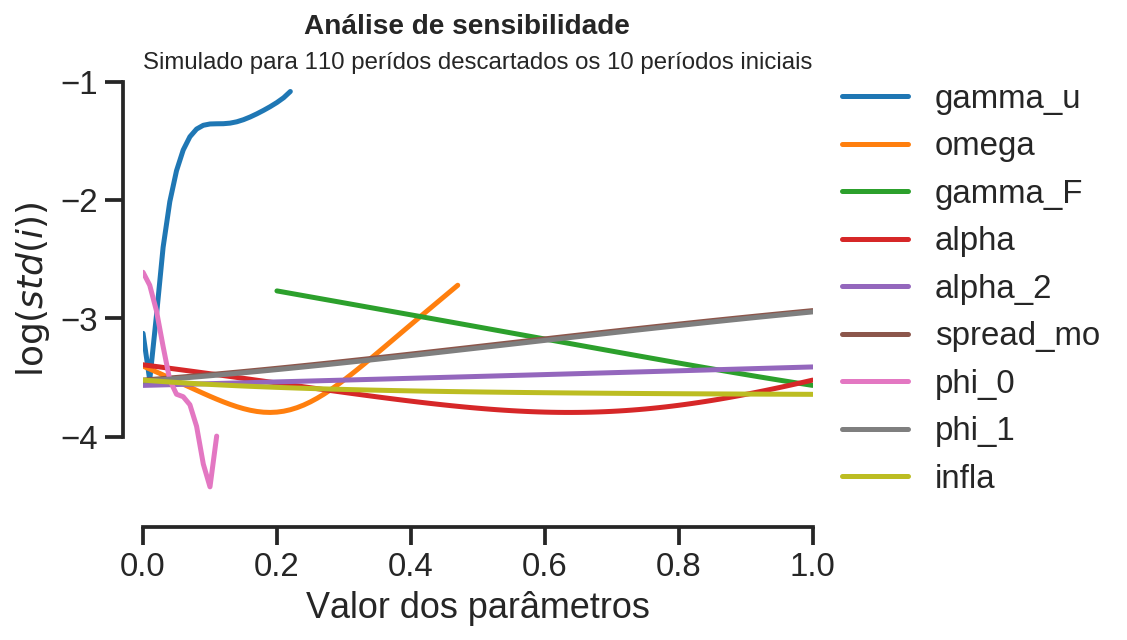

Total running time:  0:11:26.804457


,gamma_u,omega,gamma_F,alpha,alpha_2,spread_mo,phi_0,phi_1,infla
0.00,-3.125529,-3.402122,inf,-3.391093,-3.565038,-3.520330,-2.609701,-3.528739,-3.520330
0.01,-3.520330,-3.426613,inf,-3.398434,-3.563585,-3.516014,-2.718868,-3.524574,-3.524615
0.02,-2.977336,-3.451550,inf,-3.405821,-3.562129,-3.511617,-2.933602,-3.520330,-3.528739
0.03,-2.398675,-3.476886,inf,-3.413253,-3.560670,-3.507146,-3.236544,-3.516010,-3.532709
0.04,-2.013233,-3.502557,inf,-3.420728,-3.559209,-3.502599,-3.520330,-3.511614,-3.536529
...,...,...,...,...,...,...,...,...,...
0.96,inf,inf,-3.529446,-3.571237,-3.415668,-2.955270,inf,-2.966326,-3.639627
0.97,inf,inf,-3.538478,-3.558793,-3.414033,-2.949796,inf,-2.960780,-3.639843
0.98,inf,inf,-3.547423,-3.546153,-3.412396,-2.944360,inf,-2.955270,-3.640054
0.99,inf,inf,-3.556278,-3.533329,-3.410759,-2.938962,inf,-2.949797,-3.640260


In [58]:
sobol(time=100)

# Finishing

In [59]:
print("Total running time: ", datetime.now() - t1)
print("Simulation running time: ", t2 - t1)
print("Sobol running time: ", datetime.now() - t2)

Total running time:  0:13:39.070976
Simulation running time:  0:02:12.221753
Sobol running time:  0:11:26.850266


# Shock yourself

In [72]:
base = model()
df = SolveSFC(base, time=1000)
variables = df.transpose().loc['alpha':,:].index

@interact(variable = list(variables), increase = (-1,1,0.01))
def shock_yourself(variable, increase):
  try:
      shock = ShockModel(base_model = base, create_function = model(), variable = variable, increase = increase)
      plot_shock(shock = shock, filename = 'SelfShock.png')
  except Exception as e:
    print(e)
    pass